# AFL Time Series Data

In [1]:
# We begin by importing dependencies and setting the random seed for reproducibility

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.ticker as ticker

np.random.seed(42)

In [2]:
# We load the cleaned data file created by scraping the AFL stats site footywire.com.au

df = pd.read_csv('../data/full_data.csv')
# Betting data only goes back to 2010, so dropping earlier years for consistency
df = (df[(df['year'] >= 2010)]
        # Note that bye weeks and seasons before newer teams existed mark most stats as 0,
        # including the opposing team's name
        .assign(draw=((df['score'] == df['oppo_score']) & (df['oppo_team'] != '0')).astype('int'))
        .fillna(0)
        .set_index(['team', 'year', 'round_number'], drop=False)
        .sort_index())

df

home_team  last_finals_reached  \
team             year round_number                                   
Adelaide         2010 1                   0.0                  2.0   
                      2                   1.0                  2.0   
                      3                   0.0                  2.0   
                      4                   1.0                  2.0   
                      5                   0.0                  2.0   
                      6                   1.0                  2.0   
                      7                   1.0                  2.0   
                      8                   0.0                  2.0   
                      9                   1.0                  2.0   
                      10                  0.0                  2.0   
                      11                  1.0                  2.0   
                      12                  0.0                  2.0   
                      13                  1.0                  2.0   
                      14                  1.0                  2.0   
                      15                  0.0                  2.0   
                      16                  1.0                  2.0   
                      17                  0.0                  2.0   
                      18                  0.0                  2.0   
                      19                  1.0                  2.0   
                      20                  0.0                  2.0   
                      21                  0.0                  2.0   
                      22                  1.0                  2.0   
                      23                  0.0                  0.0   
                      24                  0.0                  0.0   
                 2011 1                   1.0                  0.0   
                      2                   0.0                  0.0   
                      3                   1.0                  0.0   
                      4                   0.0                  0.0   
                      5                   0.0                  0.0   
                      6                   1.0                  0.0   
...                                       ...                  ...   
Western Bulldogs 2016 19                  0.0                  1.0   
                      20                  1.0                  1.0   
                      21                  1.0                  1.0   
                      22                  0.0                  1.0   
                      23                  0.0                  1.0   
                      24                  0.0                  0.0   
                 2017 1                   0.0                  4.0   
                      2                   1.0                  4.0   
                      3                   0.0                  4.0   
                      4                   0.0                  4.0   
                      5                   1.0                  4.0   
                      6                   0.0                  4.0   
                      7                   1.0                  4.0   
                      8                   0.0                  4.0   
                      9                   0.0                  4.0   
                      10                  1.0                  4.0   
                      11                  0.0                  0.0   
                      12                  0.0                  4.0   
                      13                  1.0                  4.0   
                      14                  1.0                  4.0   
                      15                  1.0                  4.0   
                      16                  0.0                  4.0   
                      17                  0.0                  4.0   
                      18                  1.0                  4.0   
                      19                  1.0 

In [3]:
# Some useful functions

# Common column calculation across heuristics
def correct_tip(df):
    # Draws give all tippers a win
    return ((df['win'] == df['pred_win']) | (df['draw'] == 1)).astype('int')

# Negative point spread indicates the favourite
def betting_pred_win(df):
    # point_spread == 0 means it's a coin flip
    return (((df['point_spread'] < 0) | ((df['point_spread'] == 0) & (np.random.rand() >= 0.5)))
            .astype('int'))

In [4]:
# Creating betting DF with betting-odds predictions

betting_df = df[df['oppo_team'] != '0'].assign(pred_win=betting_pred_win)
betting_df.loc[:, 'correct_pred'] = correct_tip(betting_df)
betting_df.loc[:, 'pred_diff'] = (betting_df['pred_win'] - betting_df['win']).astype('int')

team_list = betting_df['team'].drop_duplicates()

betting_df

home_team  last_finals_reached  \
team             year round_number                                   
Adelaide         2010 1                   0.0                  2.0   
                      2                   1.0                  2.0   
                      3                   0.0                  2.0   
                      4                   1.0                  2.0   
                      5                   0.0                  2.0   
                      6                   1.0                  2.0   
                      7                   1.0                  2.0   
                      8                   0.0                  2.0   
                      9                   1.0                  2.0   
                      10                  0.0                  2.0   
                      11                  1.0                  2.0   
                      12                  0.0                  2.0   
                      13                  1.0                  2.0   
                      14                  1.0                  2.0   
                      15                  0.0                  2.0   
                      16                  1.0                  2.0   
                      17                  0.0                  2.0   
                      18                  0.0                  2.0   
                      19                  1.0                  2.0   
                      20                  0.0                  2.0   
                      21                  0.0                  2.0   
                      22                  1.0                  2.0   
                 2011 1                   1.0                  0.0   
                      3                   1.0                  0.0   
                      4                   0.0                  0.0   
                      5                   0.0                  0.0   
                      6                   1.0                  0.0   
                      7                   0.0                  0.0   
                      8                   1.0                  0.0   
                      9                   0.0                  0.0   
...                                       ...                  ...   
Western Bulldogs 2016 16                  1.0                  1.0   
                      17                  1.0                  1.0   
                      18                  1.0                  1.0   
                      19                  0.0                  1.0   
                      20                  1.0                  1.0   
                      21                  1.0                  1.0   
                      22                  0.0                  1.0   
                      23                  0.0                  1.0   
                 2017 1                   0.0                  4.0   
                      2                   1.0                  4.0   
                      3                   0.0                  4.0   
                      4                   0.0                  4.0   
                      5                   1.0                  4.0   
                      6                   0.0                  4.0   
                      7                   1.0                  4.0   
                      8                   0.0                  4.0   
                      9                   0.0                  4.0   
                      10                  1.0                  4.0   
                      12                  0.0                  4.0   
                      13                  1.0                  4.0   
                      14                  1.0                  4.0   
                      15                  1.0                  4.0   
                      16                  0.0                  4.0   
                      17                  0.0                  4.0   
                      18                  1.0 

## Betting odds per team over time

In [5]:
# Create df with rolling mean columns: mean win rate, mean predicted win rate (per betting odds),
# mean betting odds accuracy, and mean difference between win rate and predicted win rate.
# Using a 23 round window, because it is roughly the average season length when finals are taken into account,
# though it differs by year.
# It also gets a good balance between charts that are too choppy and rolling means that change too slowly

rolling_23 = (betting_df.groupby(level=0)
                        [['win', 'pred_win', 'correct_pred', 'pred_diff']]
                        .rolling(window=23)
                        .mean()
                        .rename(columns={'win': 'rolling_win_rate_23',
                                         'pred_win': 'rolling_pred_win_rate_23',
                                         'correct_pred': 'rolling_accuracy_23',
                                         'pred_diff': 'rolling_pred_diff_23'}))
rolling_23.index = rolling_23.index.droplevel()
# Make difference absolute value to get patterns in deviation from the real win rate
rolling_23.loc[:, 'rolling_abs_pred_diff_23'] = rolling_23['rolling_pred_diff_23'].apply(abs)

rolling_df = (pd.concat([betting_df, rolling_23], axis=1)
                .dropna()
                .assign(score_diff=lambda x: x['score'] - x['oppo_score']))
rolling_df

home_team  last_finals_reached  \
team             year round_number                                   
Adelaide         2011 1                   1.0                  0.0   
                      3                   1.0                  0.0   
                      4                   0.0                  0.0   
                      5                   0.0                  0.0   
                      6                   1.0                  0.0   
                      7                   0.0                  0.0   
                      8                   1.0                  0.0   
                      9                   0.0                  0.0   
                      10                  1.0                  0.0   
                      11                  0.0                  0.0   
                      12                  1.0                  0.0   
                      13                  0.0                  0.0   
                      14                  0.0                  0.0   
                      15                  1.0                  0.0   
                      17                  1.0                  0.0   
                      18                  0.0                  0.0   
                      19                  1.0                  0.0   
                      20                  0.0                  0.0   
                      21                  1.0                  0.0   
                      22                  0.0                  0.0   
                      23                  1.0                  0.0   
                      24                  0.0                  0.0   
                 2012 1                   0.0                  0.0   
                      2                   1.0                  0.0   
                      3                   0.0                  0.0   
                      4                   1.0                  0.0   
                      5                   1.0                  0.0   
                      6                   0.0                  0.0   
                      7                   1.0                  0.0   
                      8                   0.0                  0.0   
...                                       ...                  ...   
Western Bulldogs 2016 16                  1.0                  1.0   
                      17                  1.0                  1.0   
                      18                  1.0                  1.0   
                      19                  0.0                  1.0   
                      20                  1.0                  1.0   
                      21                  1.0                  1.0   
                      22                  0.0                  1.0   
                      23                  0.0                  1.0   
                 2017 1                   0.0                  4.0   
                      2                   1.0                  4.0   
                      3                   0.0                  4.0   
                      4                   0.0                  4.0   
                      5                   1.0                  4.0   
                      6                   0.0                  4.0   
                      7                   1.0                  4.0   
                      8                   0.0                  4.0   
                      9                   0.0                  4.0   
                      10                  1.0                  4.0   
                      12                  0.0                  4.0   
                      13                  1.0                  4.0   
                      14                  1.0                  4.0   
                      15                  1.0                  4.0   
                      16                  0.0                  4.0   
                      17                  0.0                  4.0   
                      18                  1.0 

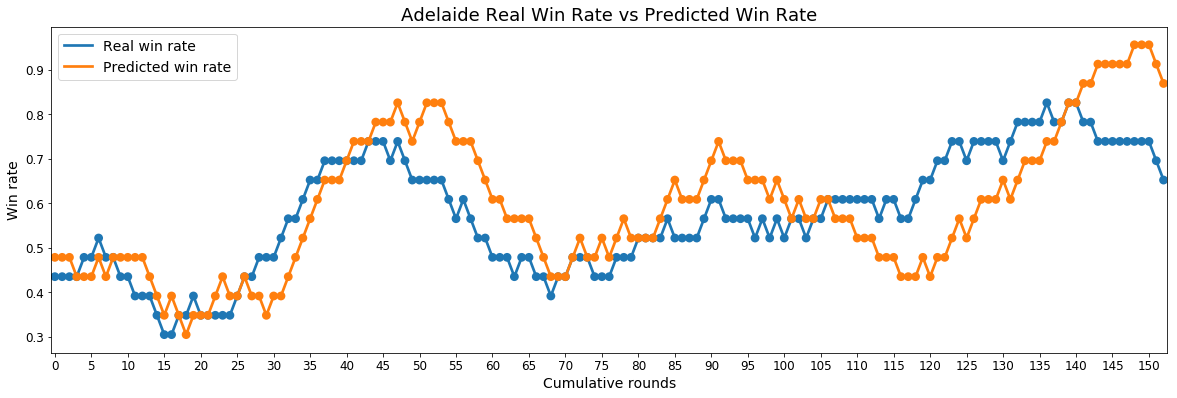

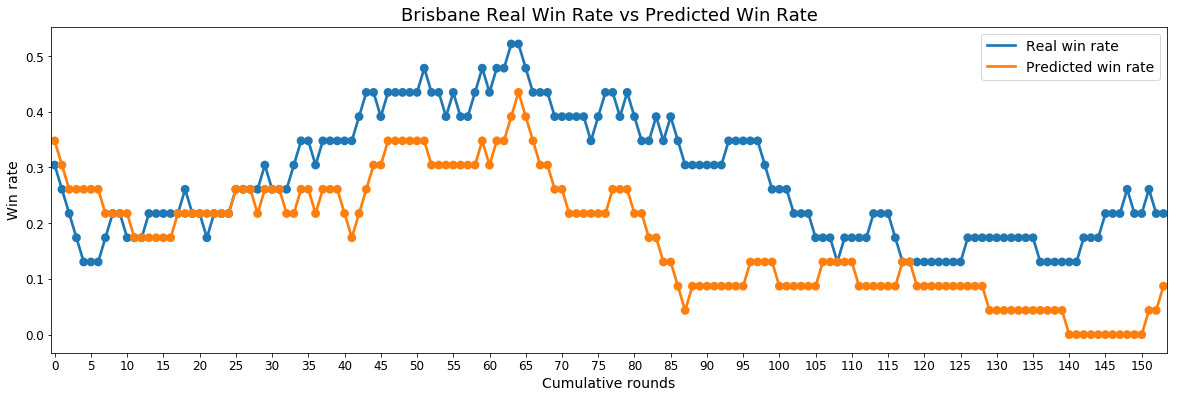

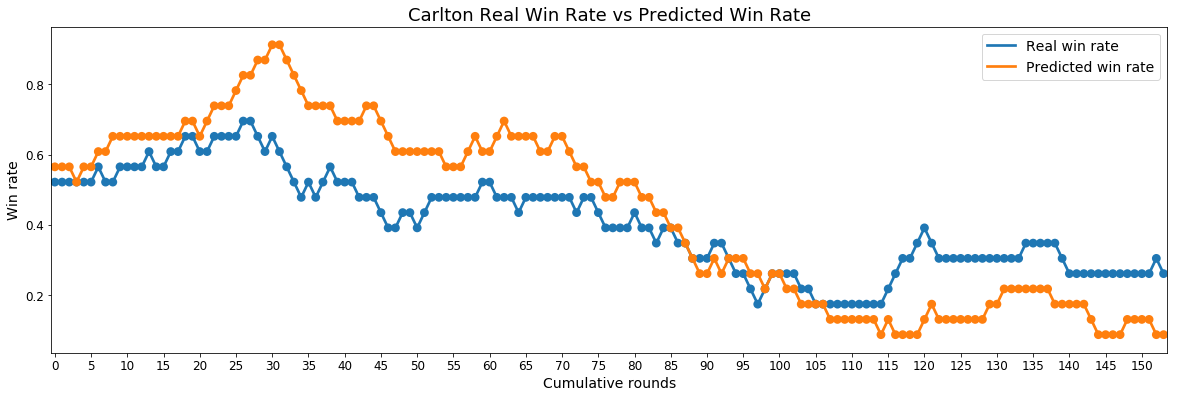

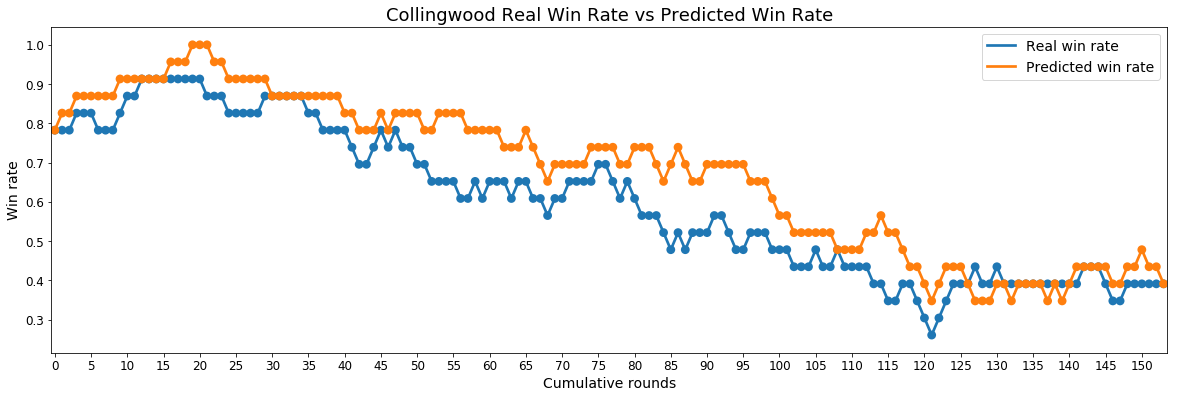

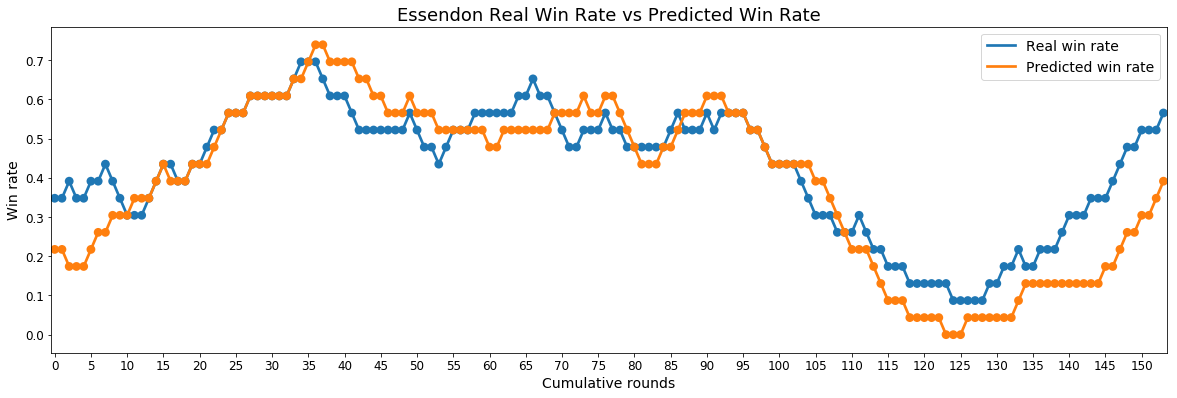

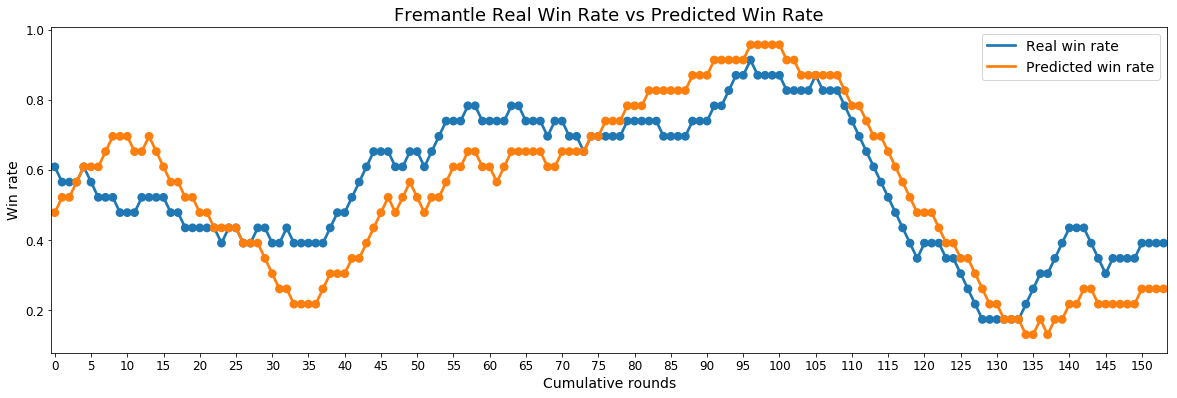

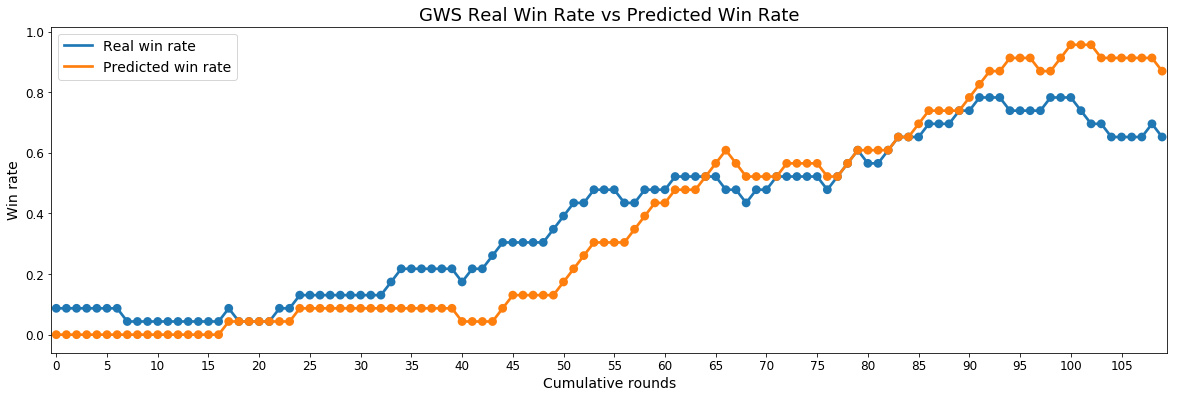

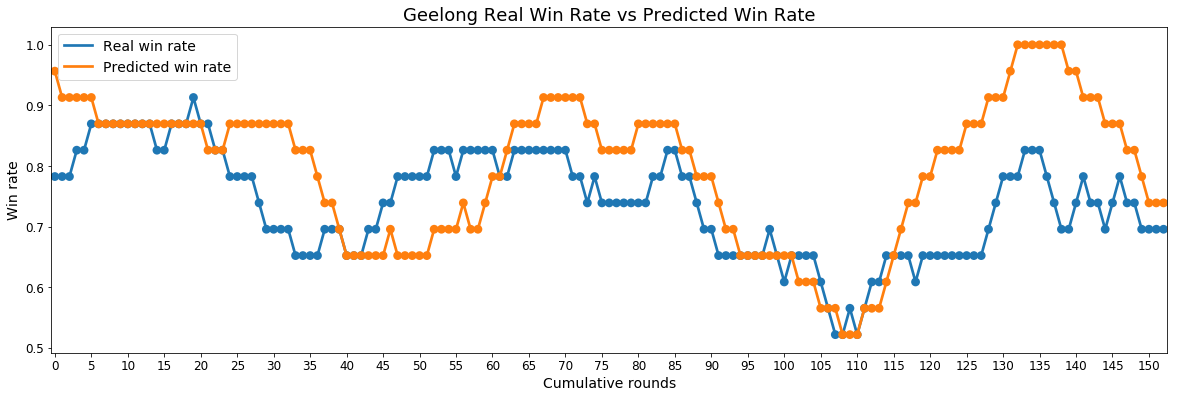

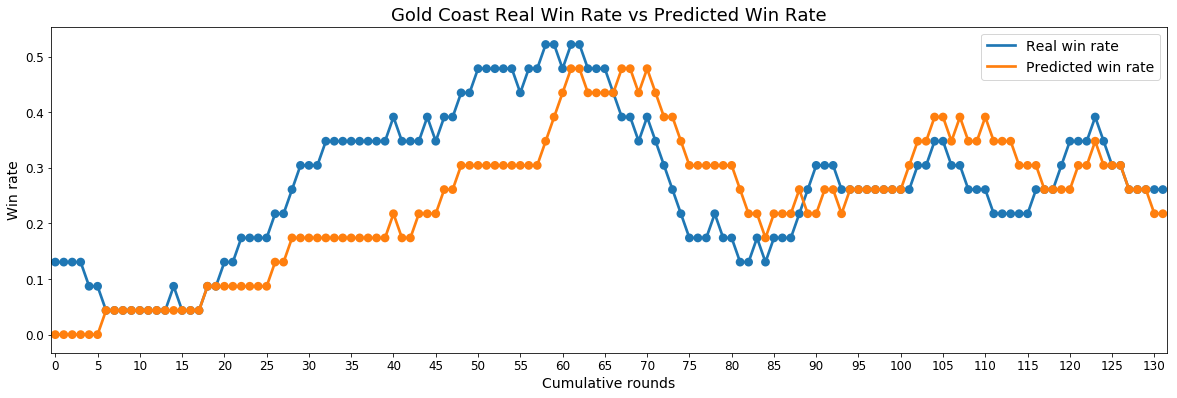

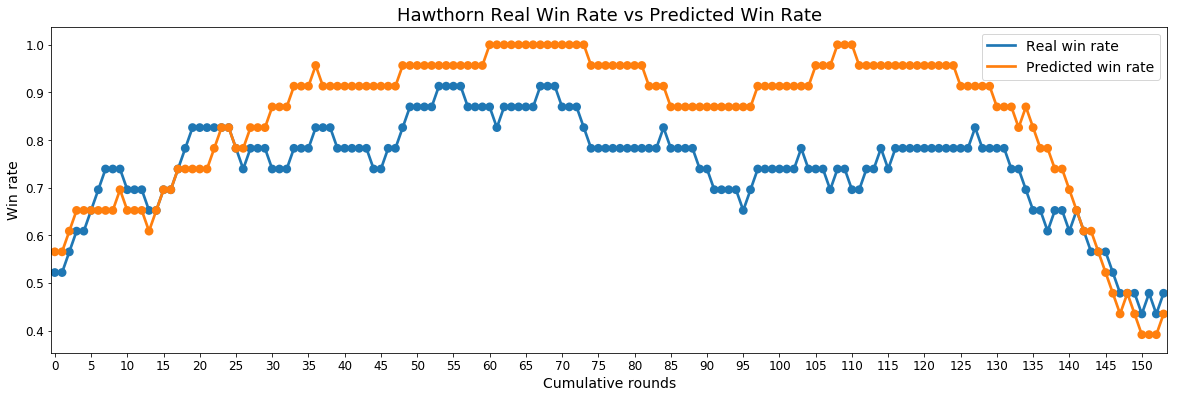

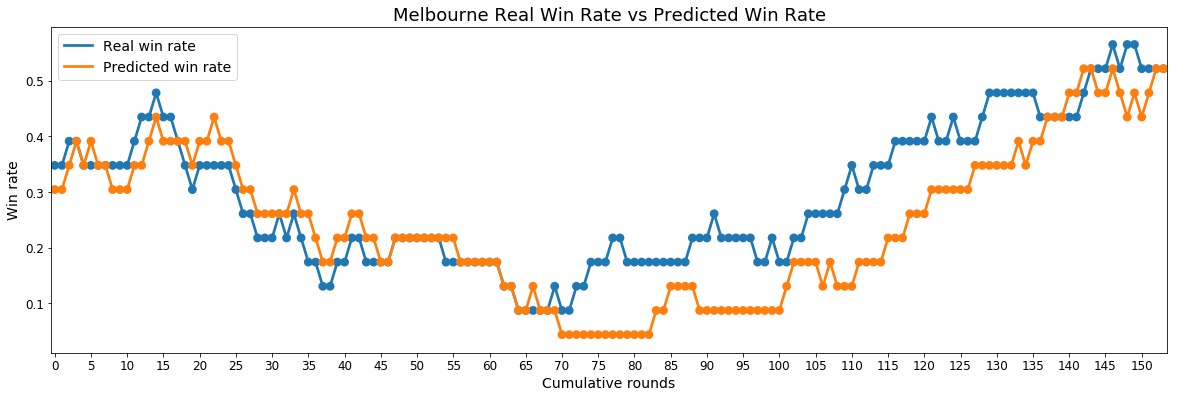

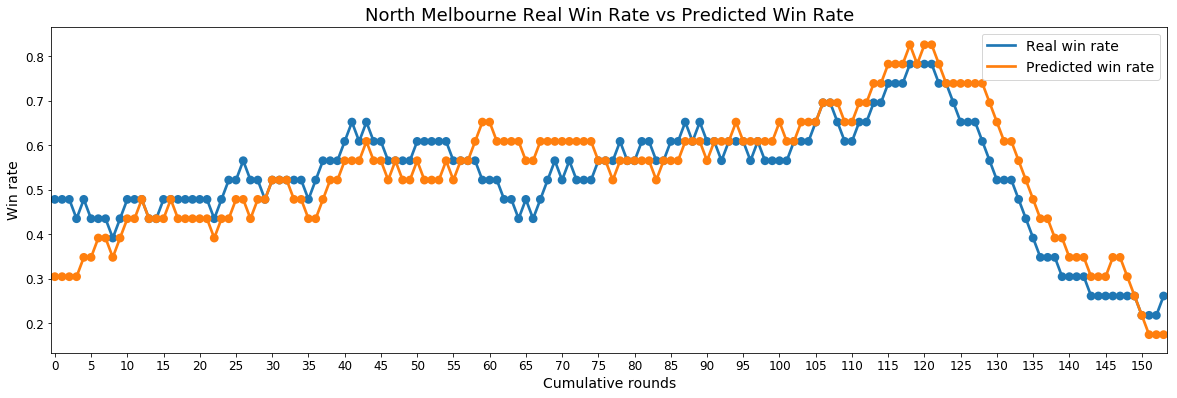

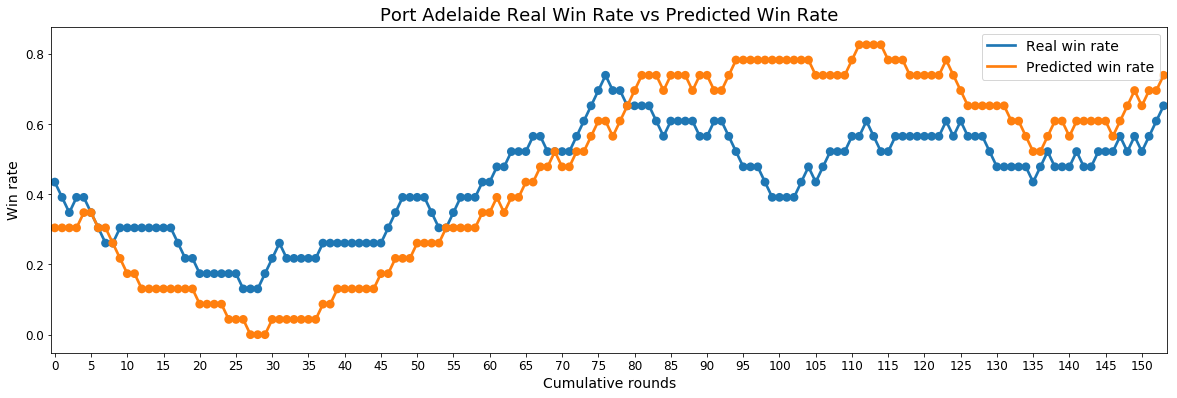

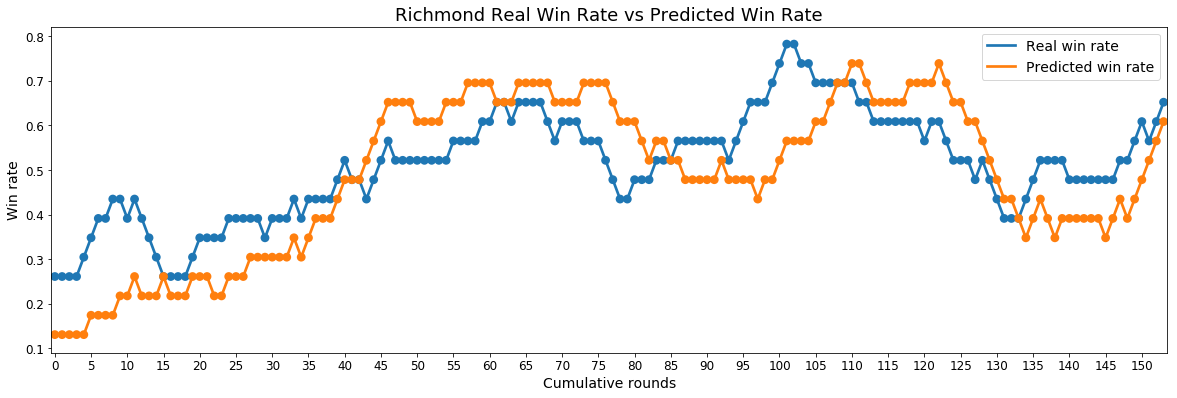

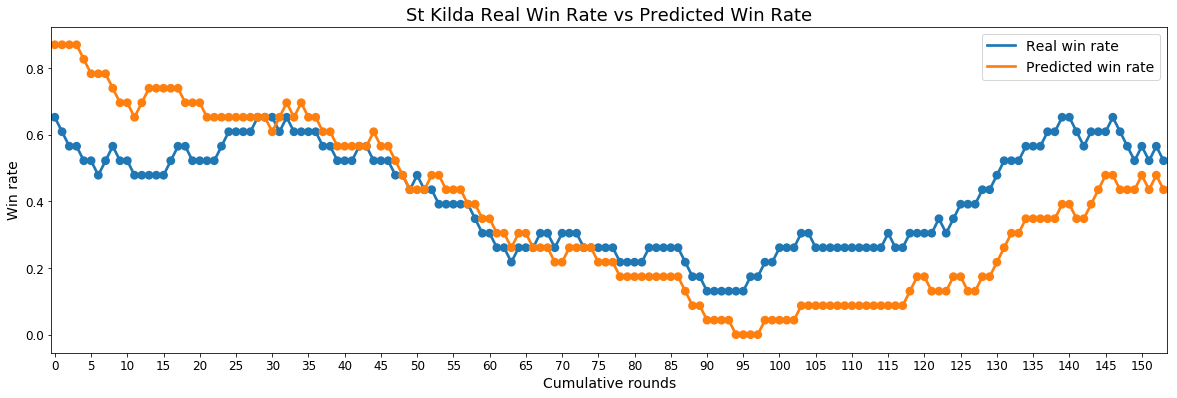

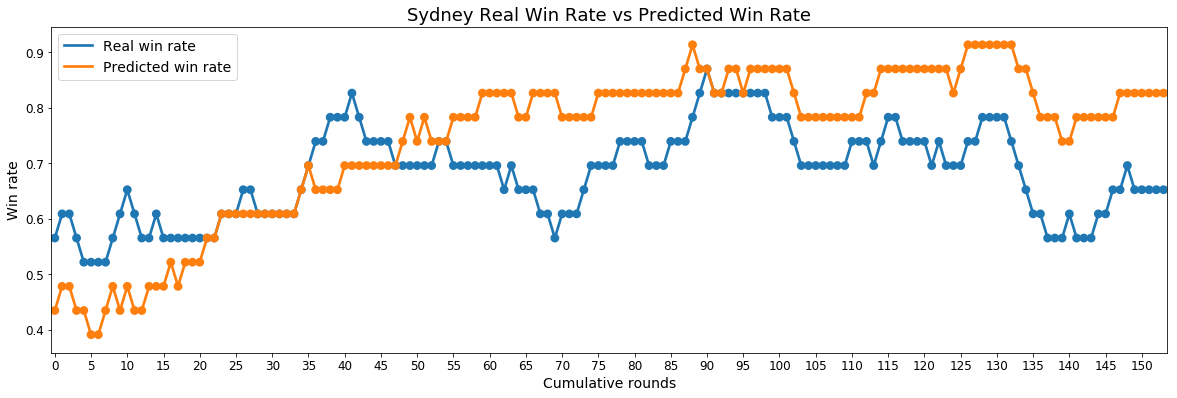

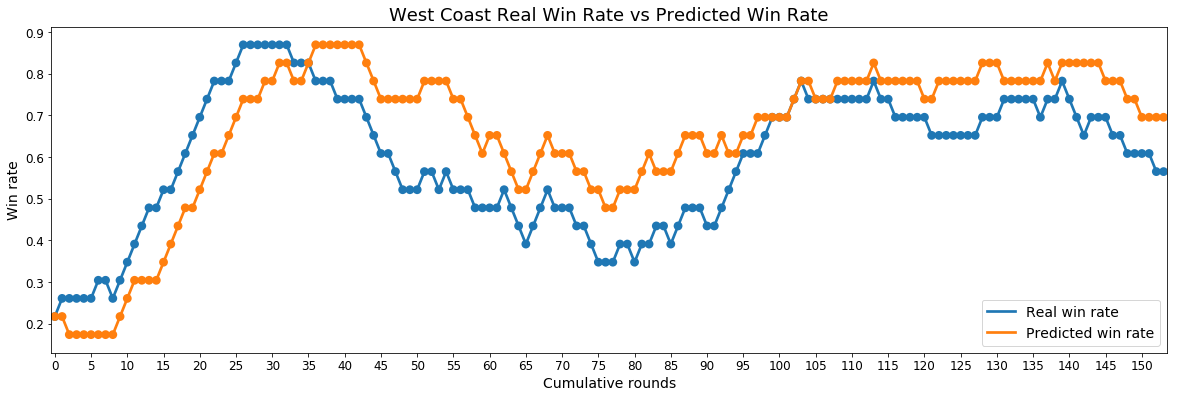

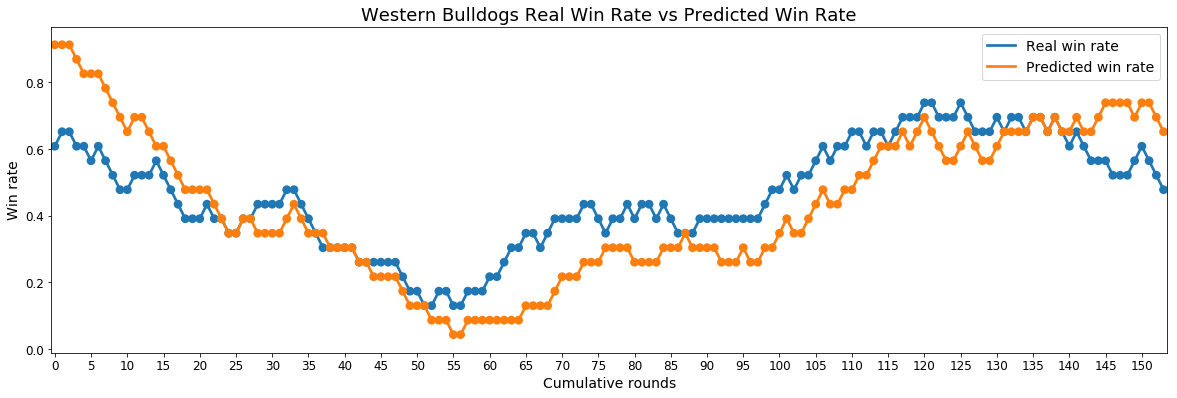

In [6]:
# Chart relationship between win rate and predicted win rate over time
# Due to dropping NaNs from the rolling means, data for the charts start in 2011 (2012 for GWS)

for team in team_list:
    team_df = rolling_df.xs(team, level=0).reset_index(drop=True)
    win_rate_dict = {'win_rate': team_df['rolling_win_rate_23'].append(team_df['rolling_pred_win_rate_23']),
                     'win_rate_type': ['win_rate'] * len(team_df) + ['pred_win_rate'] * len(team_df)}
    win_rate_df = pd.DataFrame(win_rate_dict).reset_index()

    plt.figure(figsize=(20, 6))
    ax = sns.pointplot(x='index', y='win_rate', hue='win_rate_type', data=win_rate_df, ci=None)
    plt.title('{} Real Win Rate vs Predicted Win Rate'.format(team), fontsize=18)
    plt.legend(fontsize=14, labels=('Real win rate', 'Predicted win rate'))
    plt.ylabel('Win rate', fontsize=14)
    plt.xlabel('Cumulative rounds', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    plt.show()

3 patterns:

1. Teams whose win rate changes a lot: betting odds trail the actual win rate trend by 5-15 rounds, crossing the win rate at peaks and valleys, often overshooting them by ~10%. Examples: Adelaide, Geelong, Richmond, Western Bulldogs.

2. Teams that are consistently good with long periods of flatish or steadily sloping win rates: betting odds consistently overestimate their win rates. Examples: Hawthorn, Sydney, Collingwood.

3. Teams that are consistently bad with long periods of flatish or steadily sloping win rates: betting odds consistently underestimate their win rates. Examples: Brisbane, Carlton (recent), GWS (early).

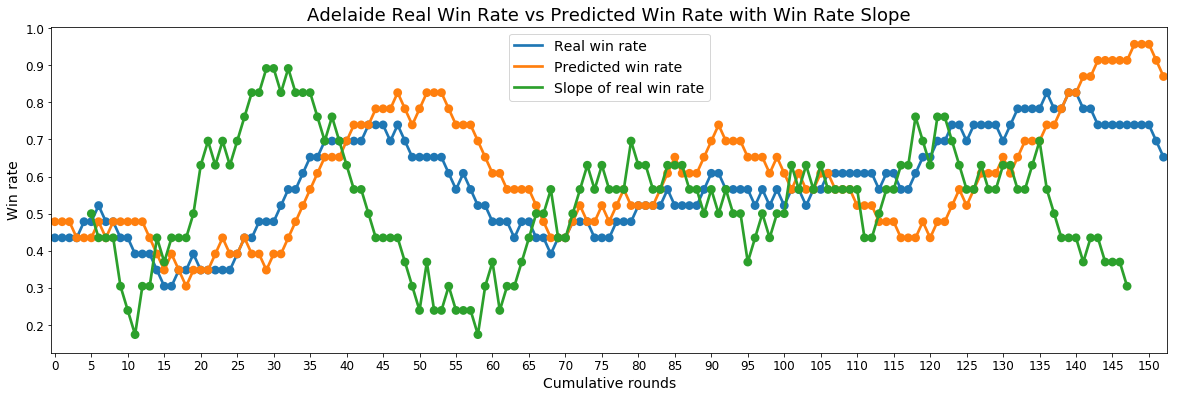

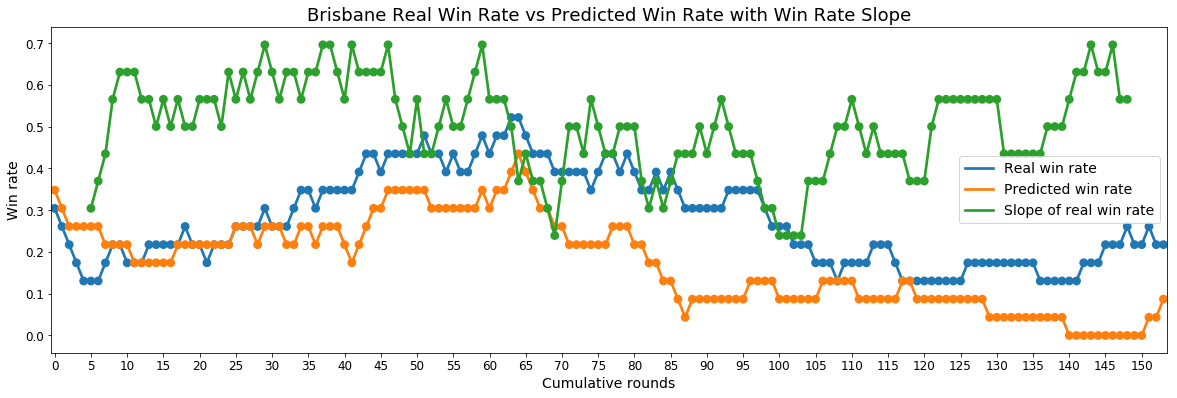

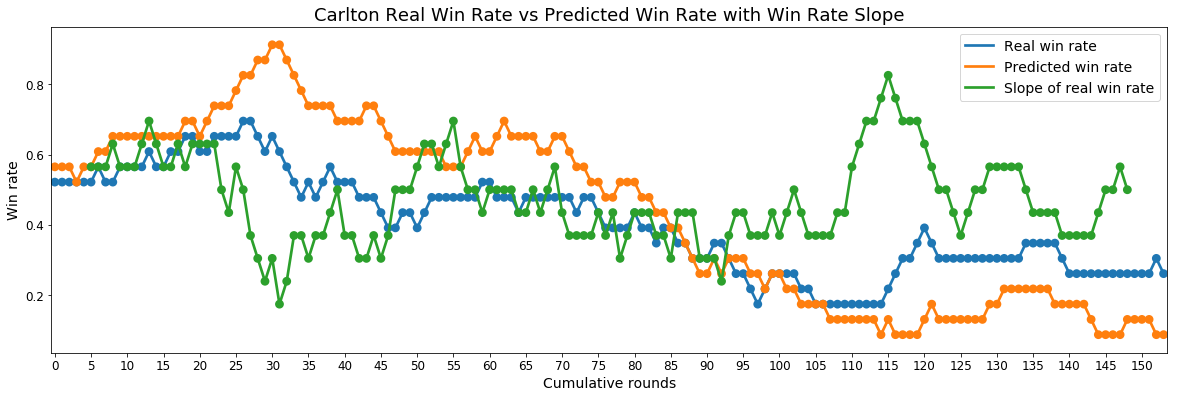

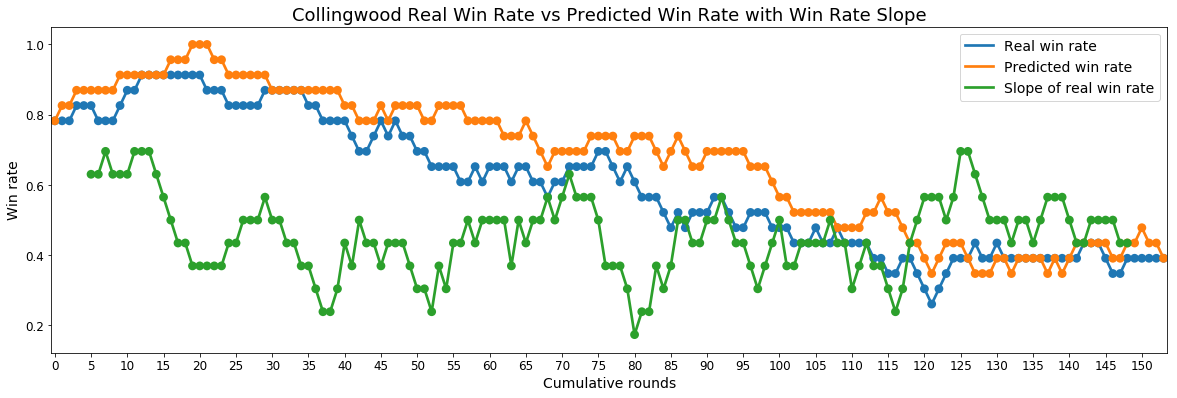

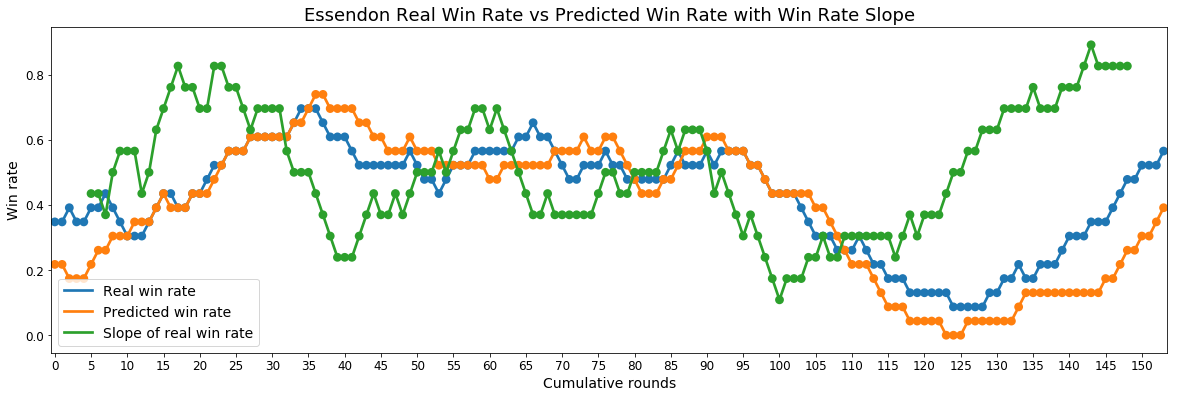

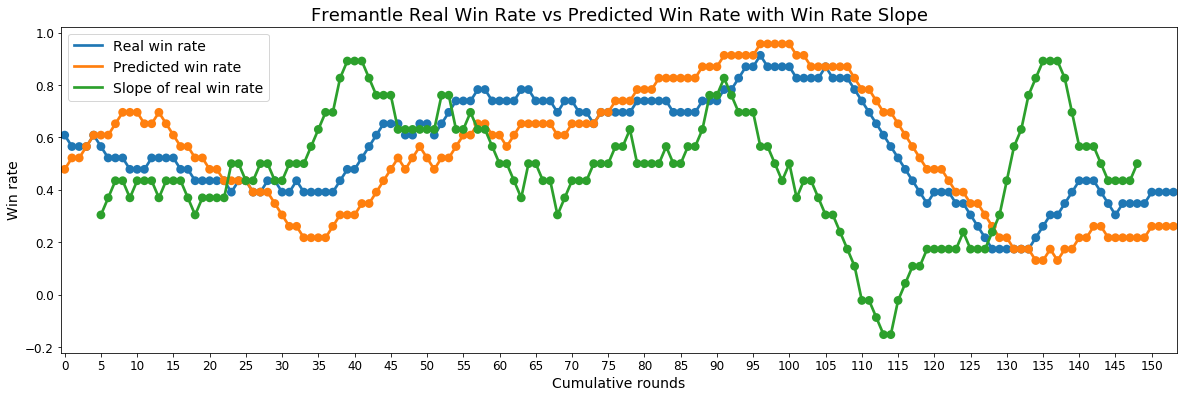

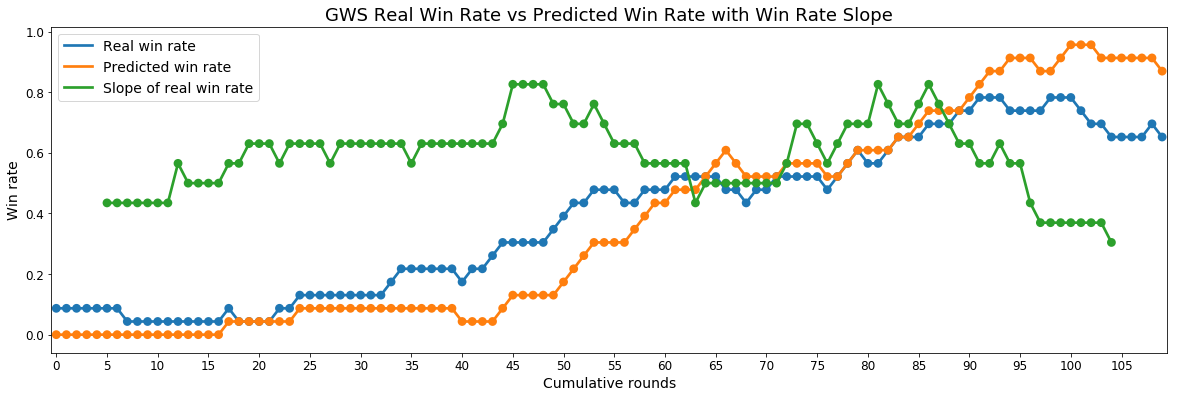

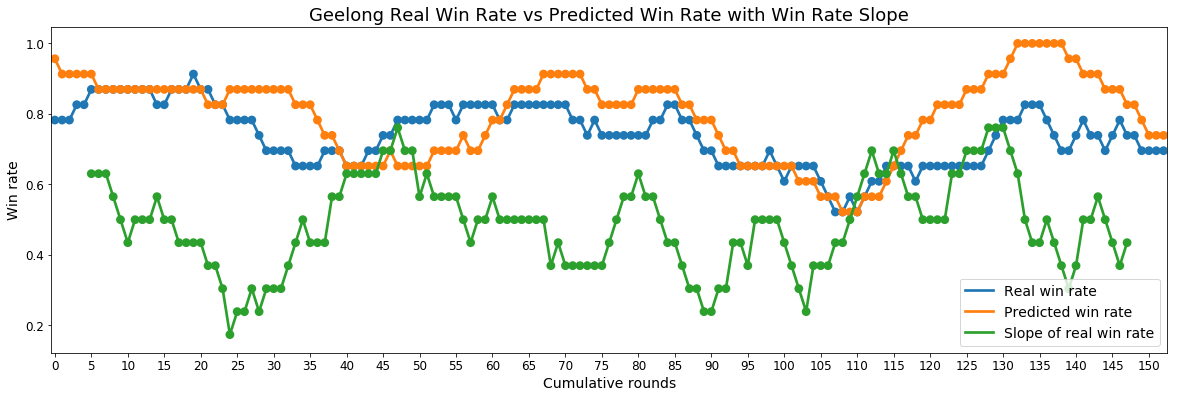

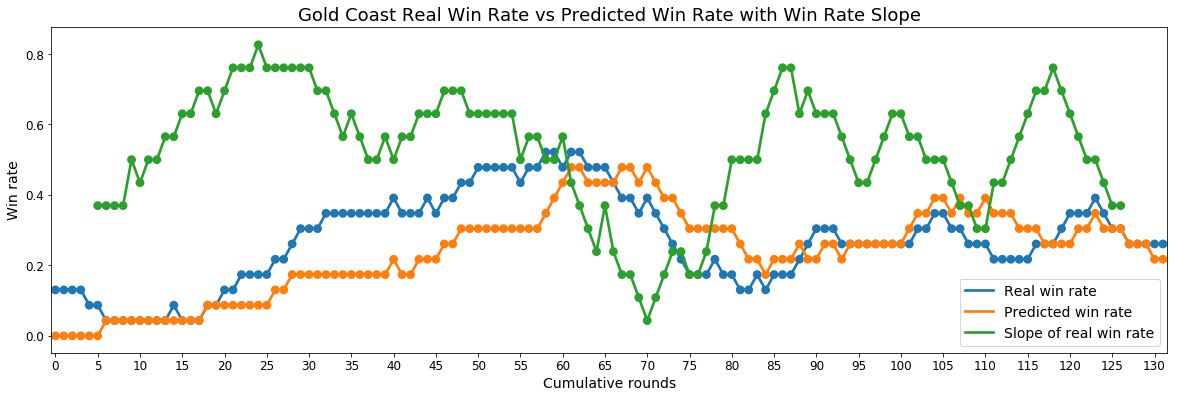

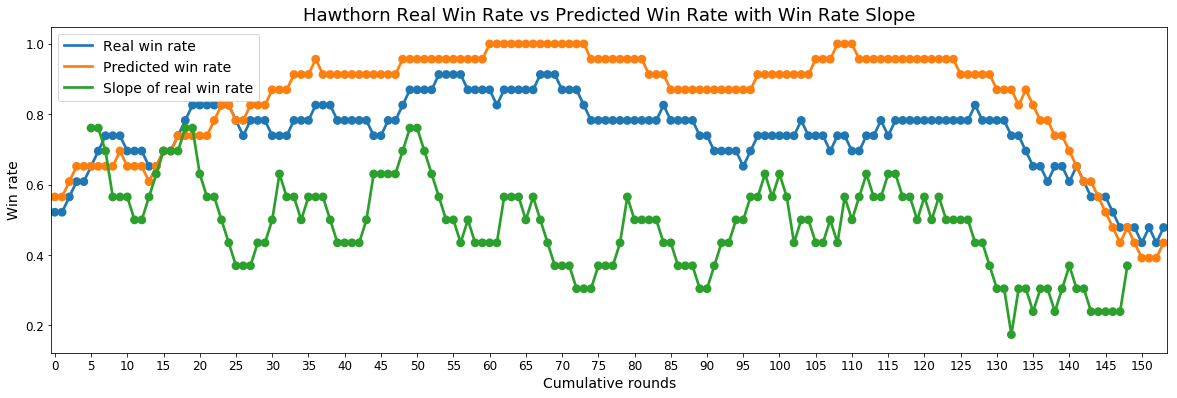

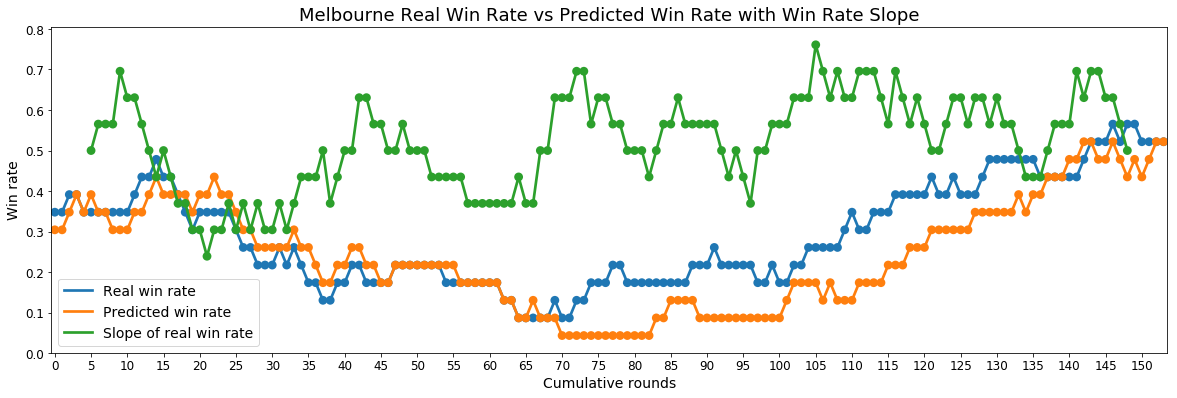

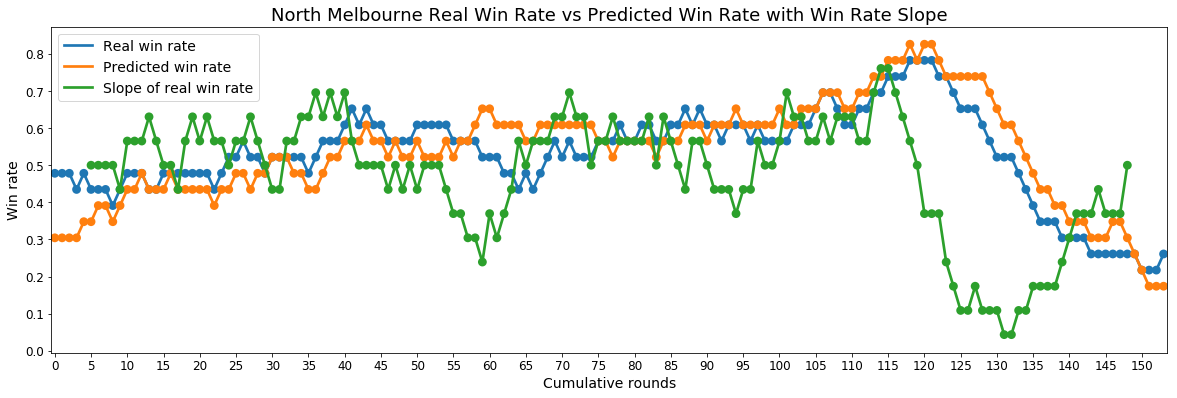

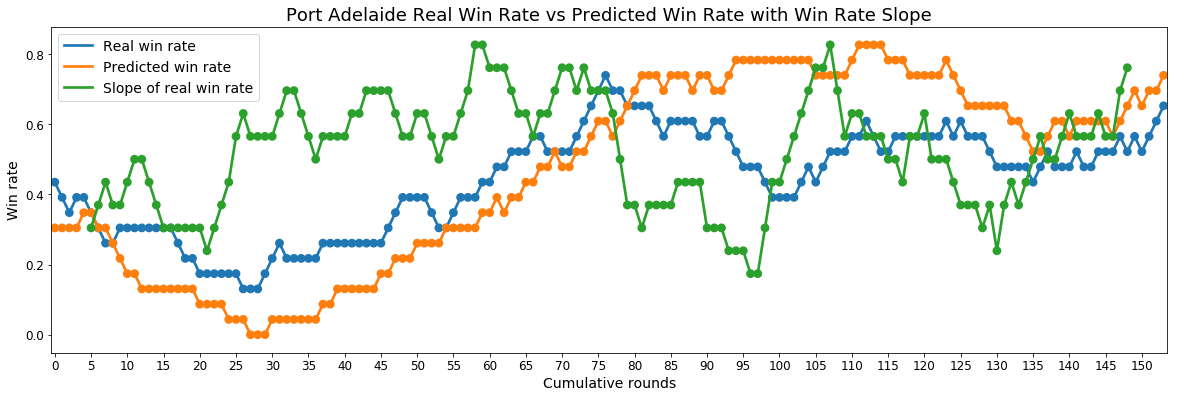

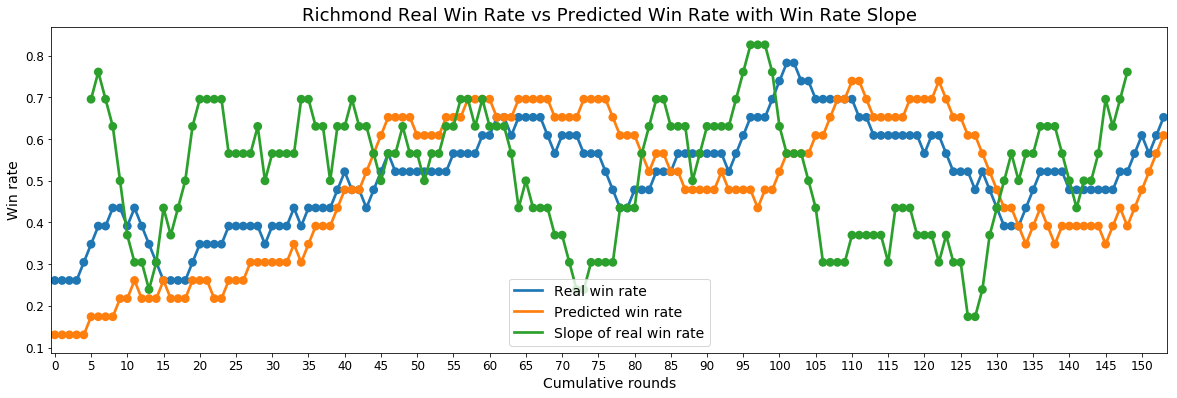

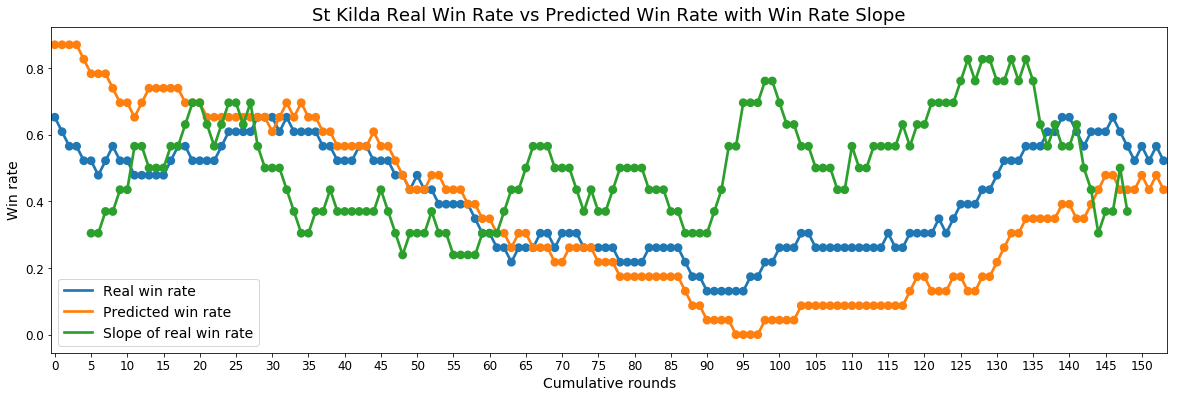

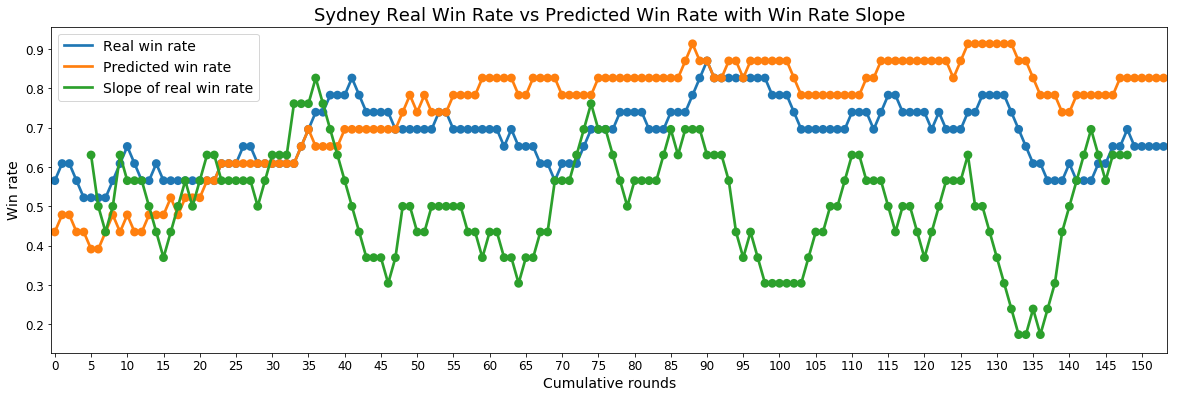

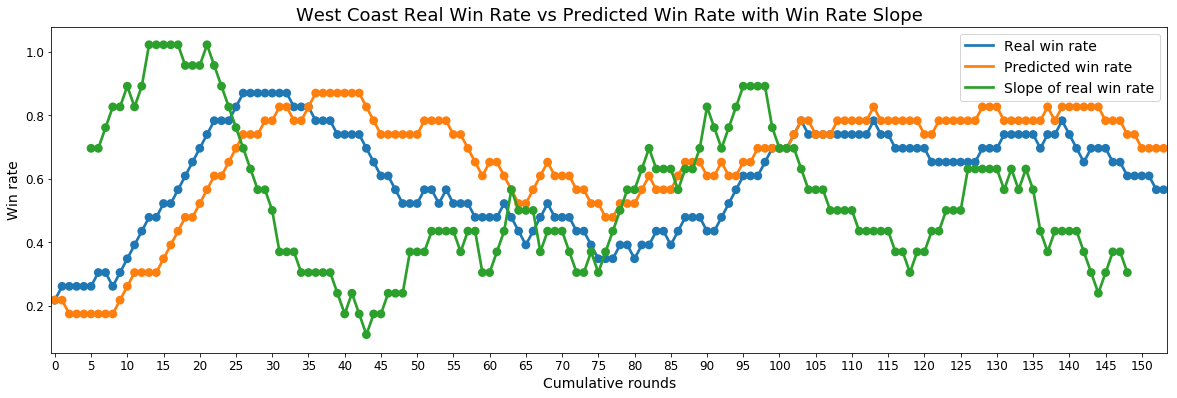

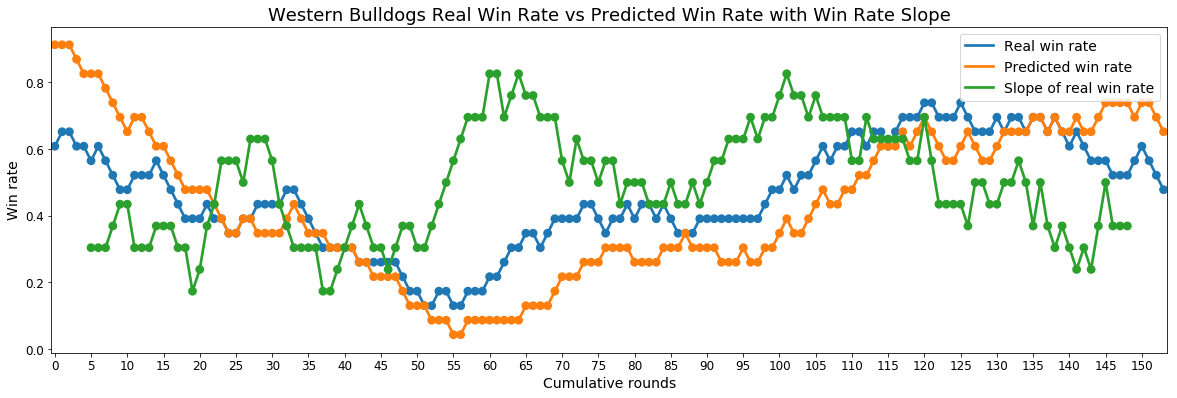

In [7]:
# Chart relationship between win rate and predicted win rate over time with the real win rate's slope added

for team in team_list:
    team_df = rolling_df.xs(team, level=0).reset_index(drop=True)
    # Setting slope at point x per change in y from x - 5 to x + 5,
    # then multiplying by 15 to account for smaller scale of y
    # and add 0.5 to center it near the win rates for visual comparison
    win_rate_slope = [(team_df['rolling_win_rate_23'][idx + 5] -
                       team_df['rolling_win_rate_23'][idx - 5]) * 1.5 + 0.5
                      for idx, _
                      in team_df['rolling_win_rate_23'][5:len(team_df) - 5].iteritems()]
    # Have to pad beginning and end with 5 NaNs each to account for how we calculated slope
    team_df.loc[:, 'win_rate_slope'] = [np.nan] * 5 + win_rate_slope + [np.nan] * 5

    win_rate_dict = {'win_rate': team_df['rolling_win_rate_23'].append([team_df['rolling_pred_win_rate_23'],
                                                                        team_df['win_rate_slope']]),
                     'win_rate_type': (['win_rate'] * len(team_df) +
                                       ['pred_win_rate'] * len(team_df) +
                                       ['win_rate_slope'] * len(team_df))
                    }
    win_rate_df = pd.DataFrame(win_rate_dict).reset_index()

    plt.figure(figsize=(20,6))
    ax = sns.pointplot(x='index', y='win_rate', hue='win_rate_type', data=win_rate_df, ci=None)
    plt.title('{} Real Win Rate vs Predicted Win Rate with Win Rate Slope'.format(team), fontsize=18)
    plt.legend(fontsize=14, labels=('Real win rate', 'Predicted win rate', 'Slope of real win rate'))
    plt.ylabel('Win rate', fontsize=14)
    plt.xlabel('Cumulative rounds', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    plt.show()

It's difficult to quantify the relationship between real win rate and the betting odds' predicted win rate, but combining those two stats with the slope of the real win rate could indicate to a machine learning algorithm when the odds are likely to over- or under-estimate a team's chances.

It's also possible that a model would also need a measure of a team's overall dynamism (i.e. does their win rate rise and fall from season to season or is it relatively flat for multiple seasons?) to correctly account for betting odds' biases. However, it might be redundant, because if the slope is large (high or low) there's a limit to how long it can remain like that before flattening out (a team can't increase or decrease it's win rate forever). I'll hold off on testing this stuff until I start working with ML algorithms.

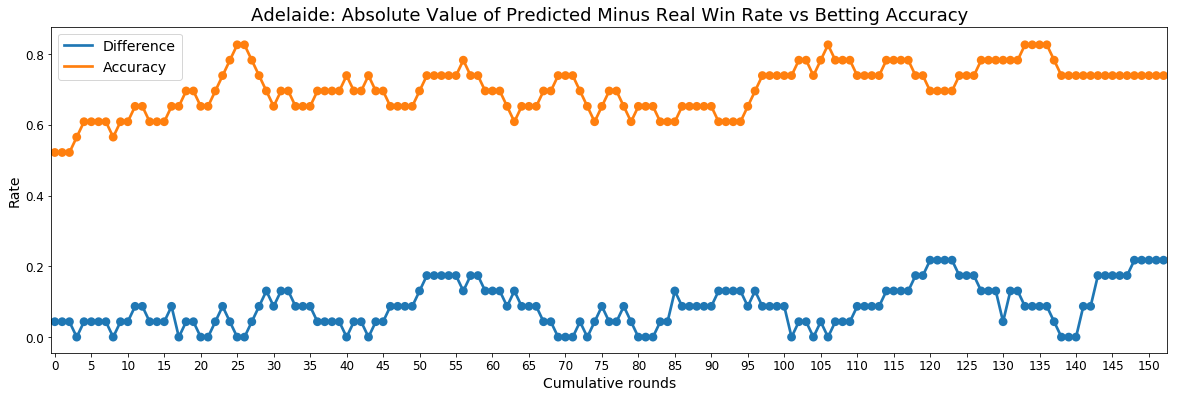

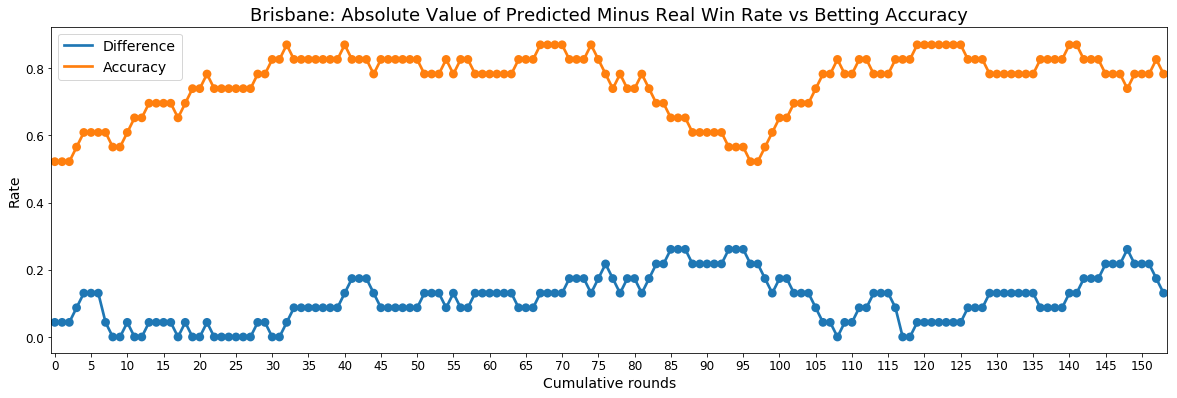

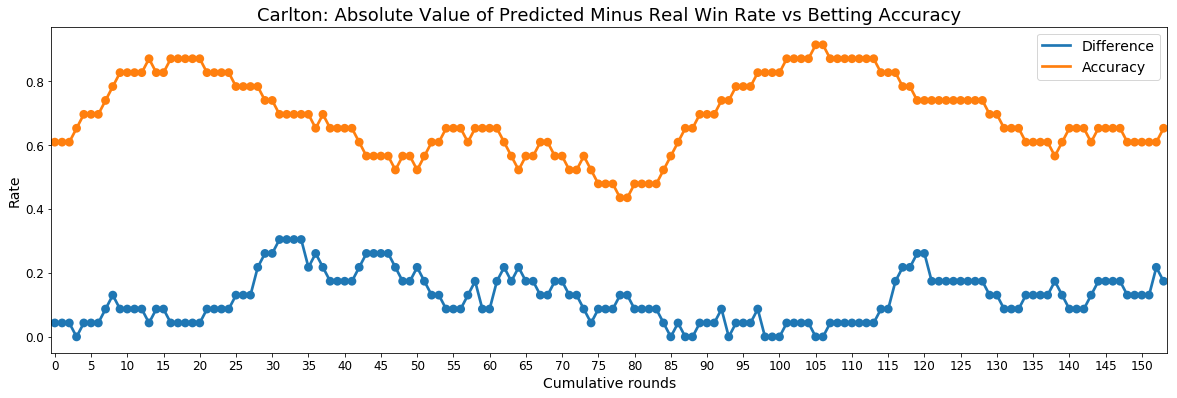

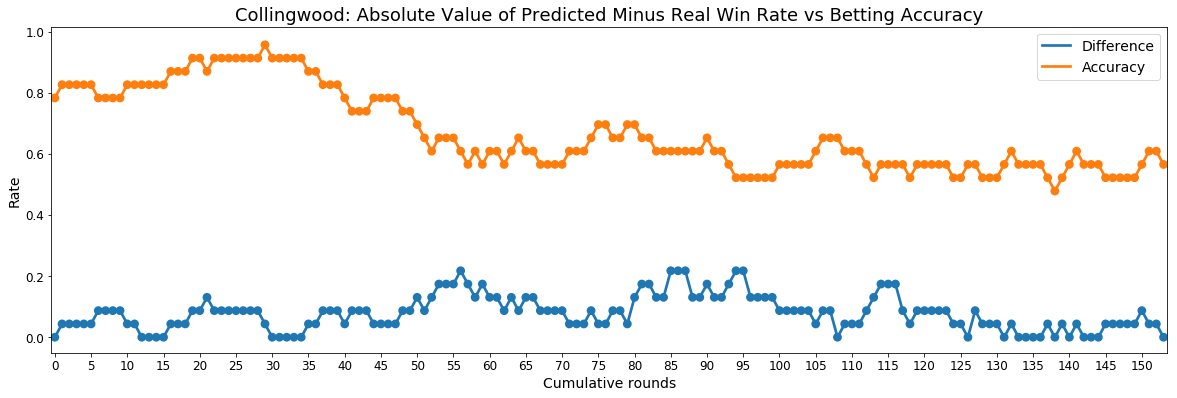

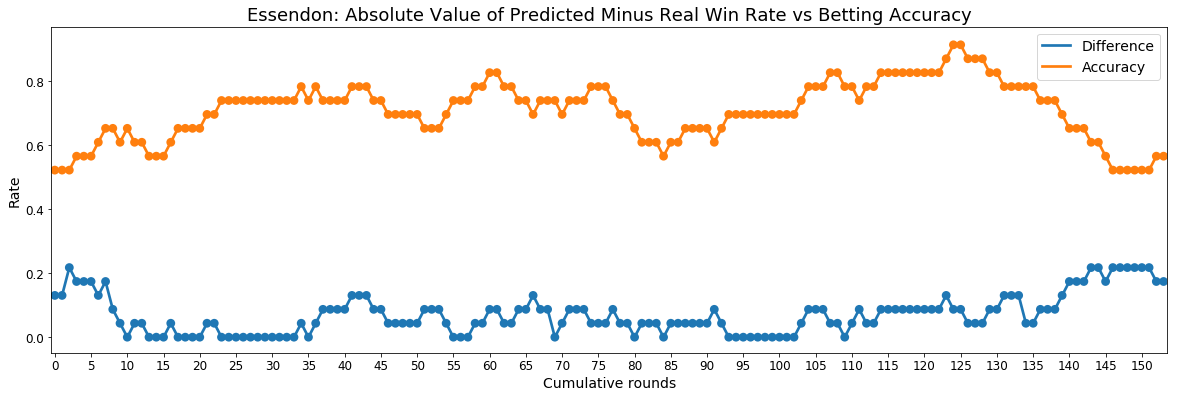

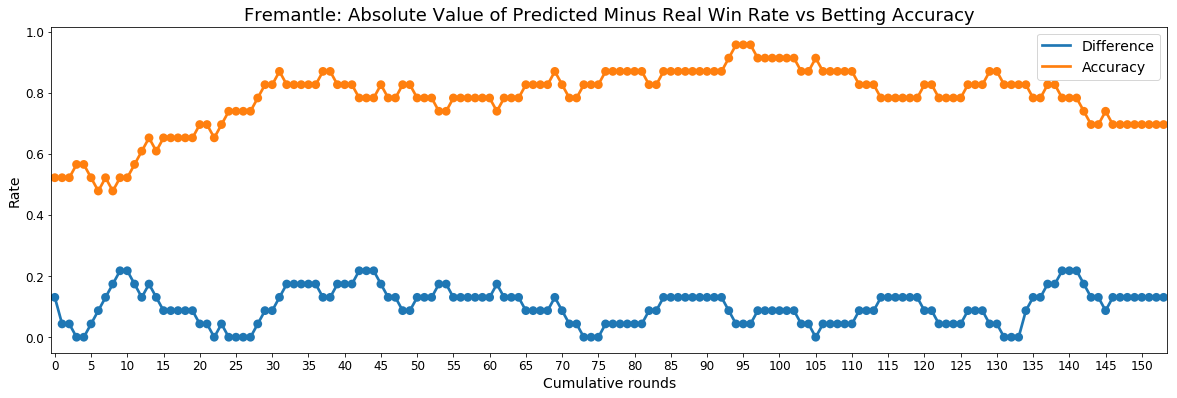

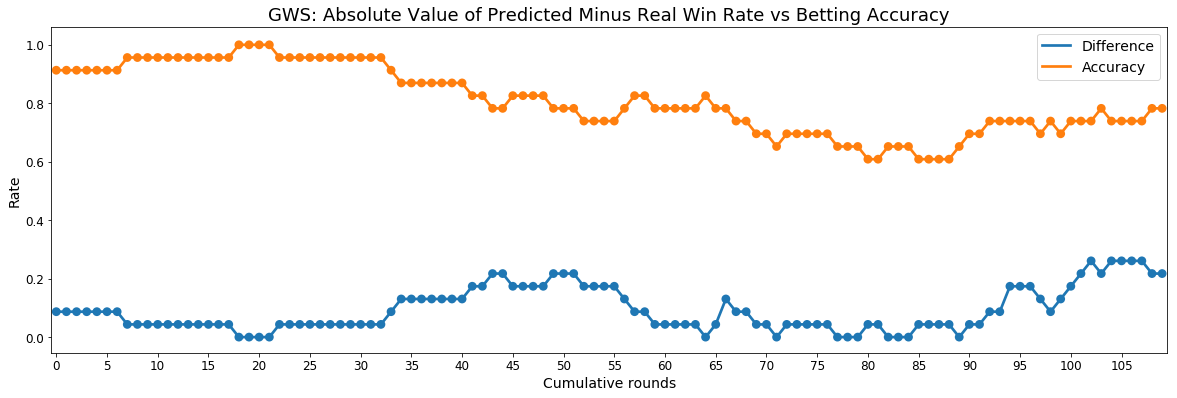

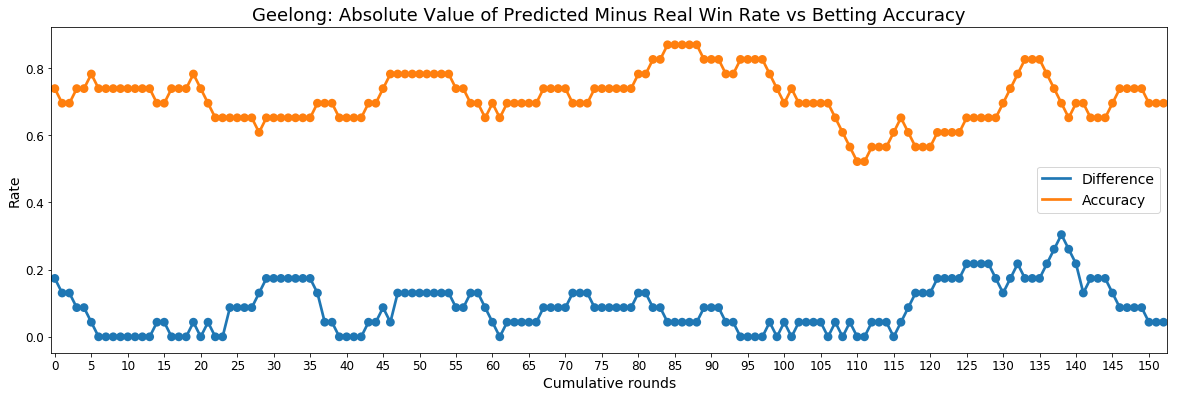

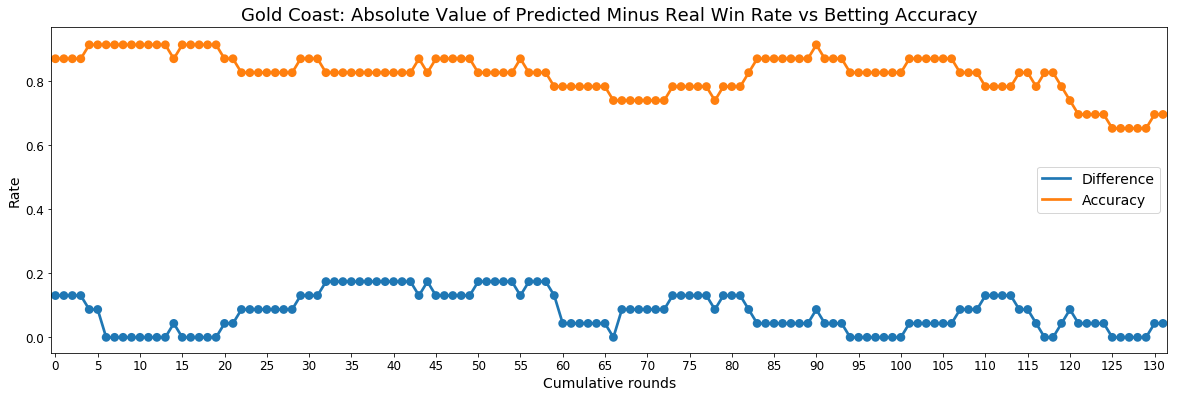

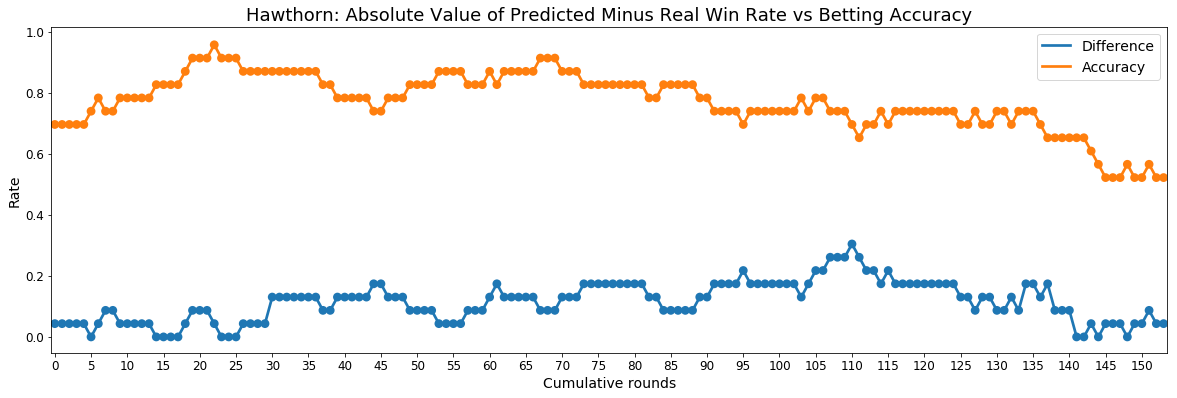

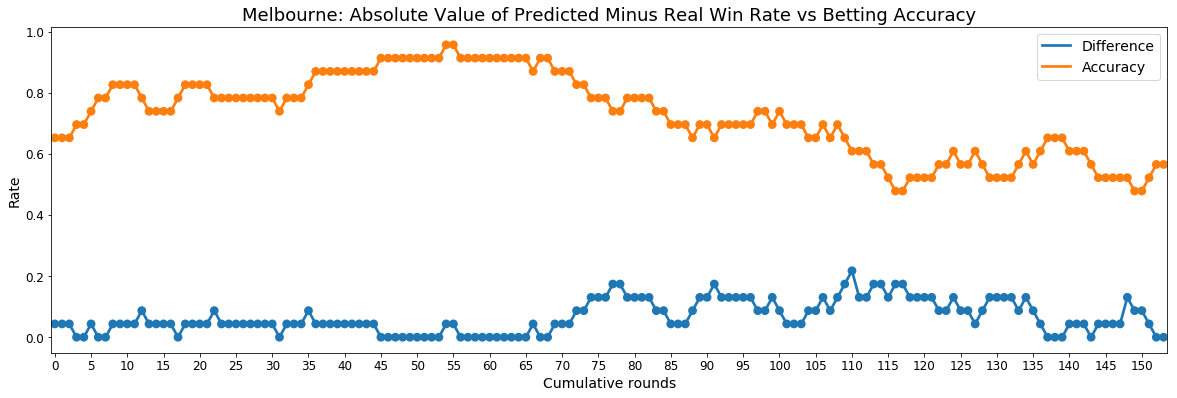

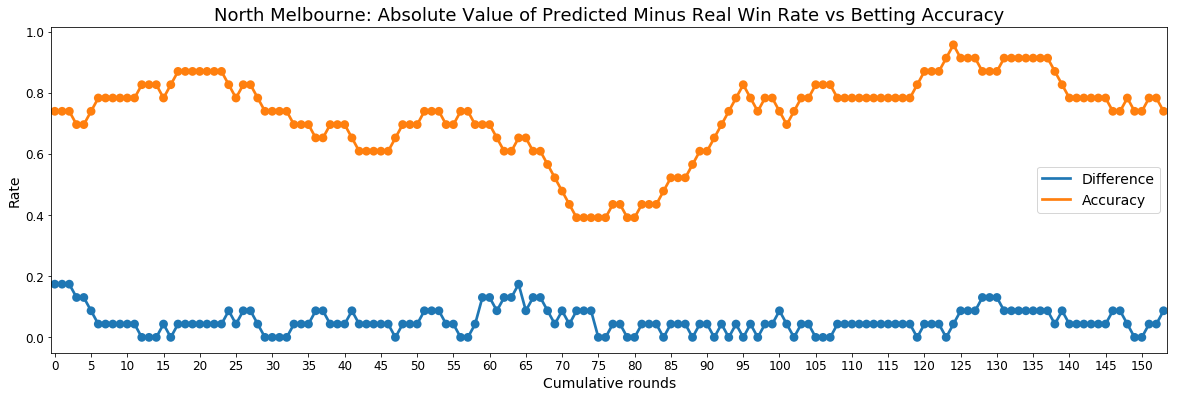

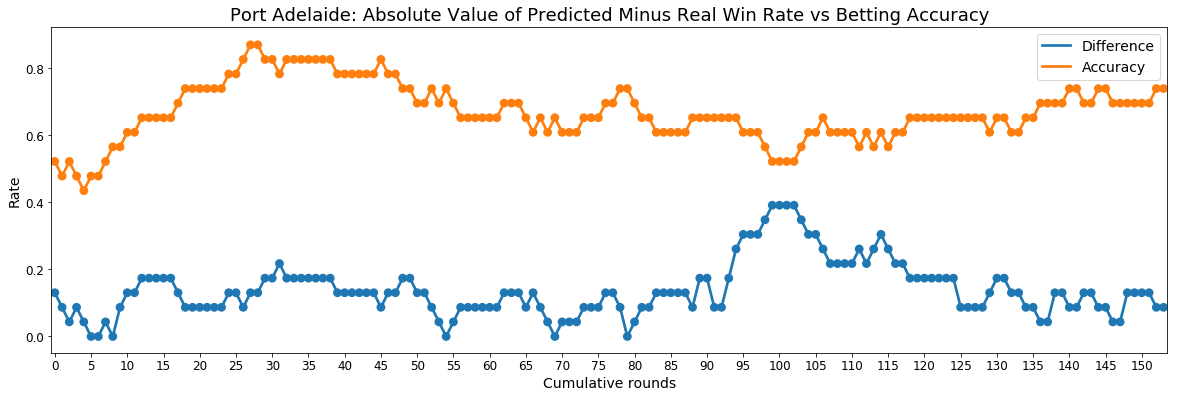

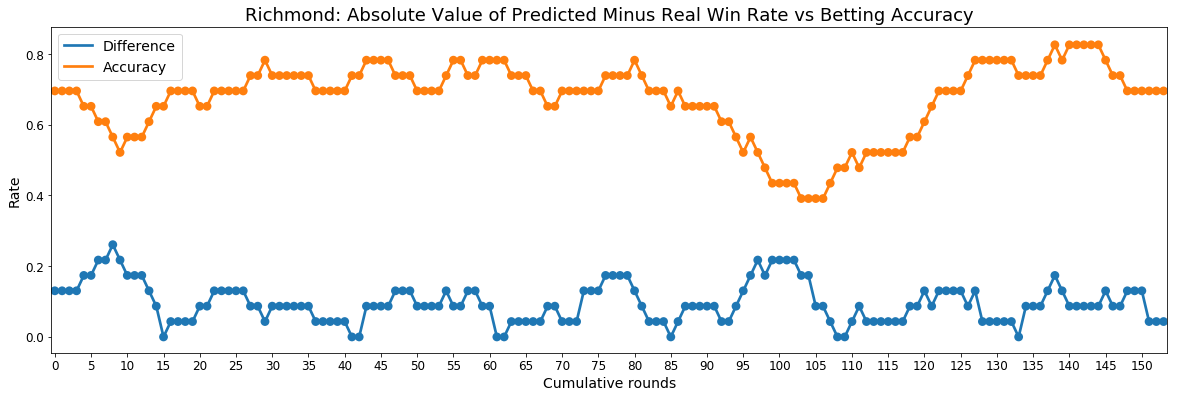

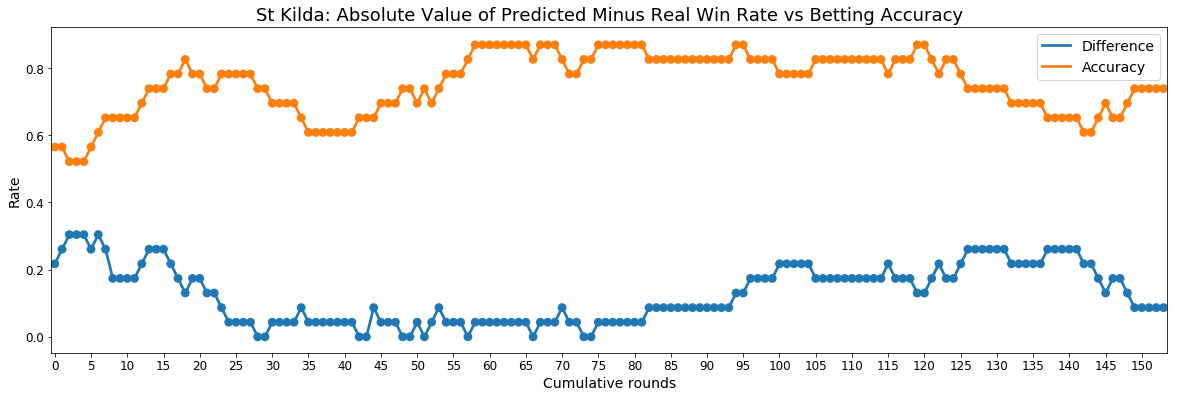

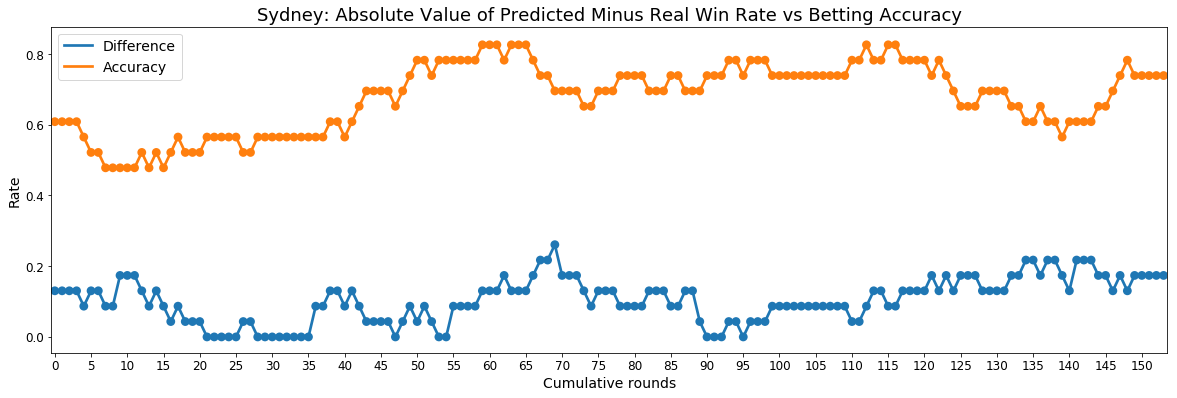

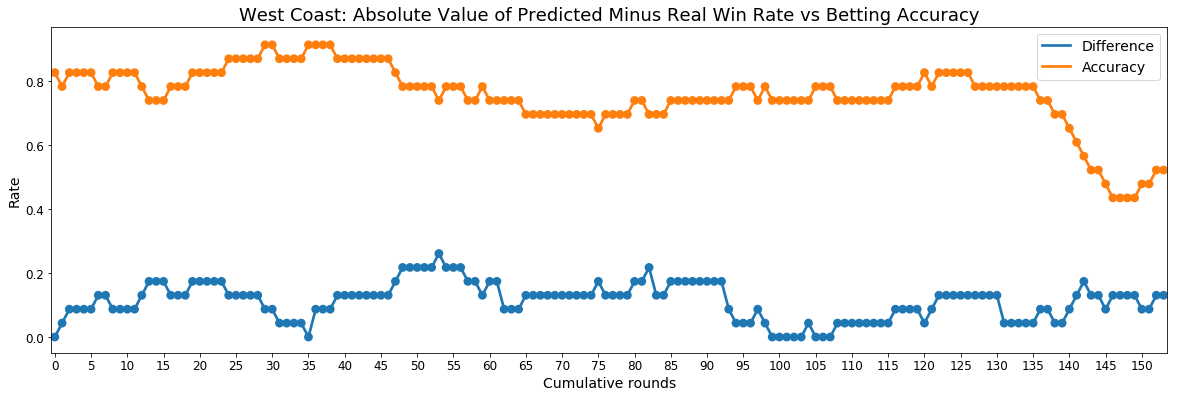

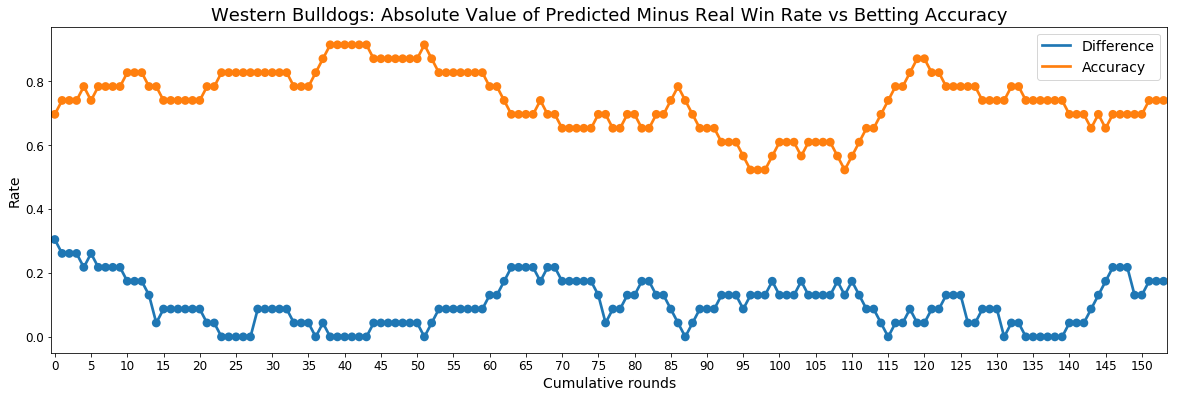

In [8]:
# Prediction error vs betting accuracy

for team in team_list:
    team_df = rolling_df.xs(team, level=0).reset_index(drop=True)
        
    win_rate_dict = {'win_rate': (team_df['rolling_abs_pred_diff_23']).append(team_df['rolling_accuracy_23']),
                     'win_rate_type': ['rolling_pred_diff'] * len(team_df) + ['rolling_accuracy'] * len(team_df)}
    win_rate_df = pd.DataFrame(win_rate_dict).reset_index()

    plt.figure(figsize=(20,6))
    ax = sns.pointplot(x='index', y='win_rate', hue='win_rate_type', data=win_rate_df, ci=None)
    plt.title('{}: Absolute Value of Predicted Minus Real Win Rate vs Betting Accuracy'.format(team), fontsize=18)
    plt.legend(fontsize=14, labels=('Difference', 'Accuracy'))
    plt.ylabel('Rate', fontsize=14)
    plt.xlabel('Cumulative rounds', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    plt.show()

Betting accuracy looks to be negatively correlated with the absolute value of predicted win rate minus real win rate, which makes sense, but it's hard to say if this is any more useful than just using the rolling accuracy of betting odds. It seems to be duplicating information without adding additional insight.

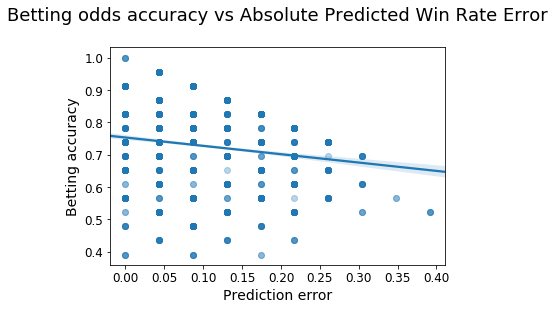

In [9]:
# Scatter plot of accuracy vs absolute prediction error

# Add alpha due to the extreme overlap of many points spread over a limited range of values
sns.regplot(x='rolling_abs_pred_diff_23', y='rolling_accuracy_23',
            data=rolling_df.reset_index(drop=True), scatter_kws={'alpha':0.3})

plt.title('Betting odds accuracy vs Absolute Predicted Win Rate Error\n', fontsize=18)
plt.ylabel('Betting accuracy', fontsize=14)
plt.xlabel('Prediction error', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()

There is a weak relationship between betting odds' biases (time lag, general over- or underestimating certain teams) and their prediction accuracy, but the plot is too noisy to say anything with confidence.

## Comparison of week-on-week win rates

In [10]:
# Create DF of wins by week, structured as t-0 (this week), t-1, t-2, ..., t-n

win_series = (betting_df['win'] + (betting_df['draw'] * 0.5)).rename('win')
time_series_cols = []

for n in range(23):
    win_col = win_series.groupby(level=0).shift(n).rename('win_{}'.format(n))
    time_series_cols.append(win_col)

time_series_df = pd.concat(time_series_cols, axis=1).dropna()

In [11]:
# Create DF of predicted wins by week, structured as t-0 (this week), t-1, t-2, ..., t-n

pred_series = betting_df['pred_win'].rename('win')
pred_series_cols = []

for n in range(23):
    pred_col = pred_series.groupby(level=0).shift(n).rename('pred_win_{}'.format(n))
    pred_series_cols.append(pred_col)

pred_series_df = pd.concat(pred_series_cols, axis=1).dropna()

In [12]:
# For winners in a given week, how many win the week after, how many the week after that, etc.
first_week_winners = time_series_df[time_series_df['win_22'] == 1]
first_week_winners.mean()

win_0     0.570045
win_1     0.531669
win_2     0.561475
win_3     0.576006
win_4     0.548063
win_5     0.565574
win_6     0.576379
win_7     0.567809
win_8     0.562221
win_9     0.571908
win_10    0.575633
win_11    0.574888
win_12    0.562221
win_13    0.568182
win_14    0.564456
win_15    0.562221
win_16    0.561475
win_17    0.560358
win_18    0.576379
win_19    0.586066
win_20    0.567064
win_21    0.566319
win_22    1.000000
dtype: float64

In [13]:
print('Overall win rate of round t-22 winners:', first_week_winners.mean().drop('win_22').mean())

Overall win rate of round t-22 winners: 0.566200379352


In [14]:
# For losers in a given week, how many lose the week after, how many the week after that, etc.
first_week_losers = time_series_df[time_series_df['win_22'] == 0]
first_week_losers.mean()

win_0     0.440387
win_1     0.478763
win_2     0.445976
win_3     0.432191
win_4     0.460879
win_5     0.447839
win_6     0.432563
win_7     0.440387
win_8     0.444486
win_9     0.434799
win_10    0.430328
win_11    0.430700
win_12    0.445231
win_13    0.435544
win_14    0.438525
win_15    0.439642
win_16    0.441505
win_17    0.440387
win_18    0.427347
win_19    0.411699
win_20    0.431446
win_21    0.435917
win_22    0.000000
dtype: float64

In [15]:
print('Overall win rate of round t-0 losers:', first_week_losers.mean().drop('win_22').mean())

Overall win rate of round t-0 losers: 0.439388294269


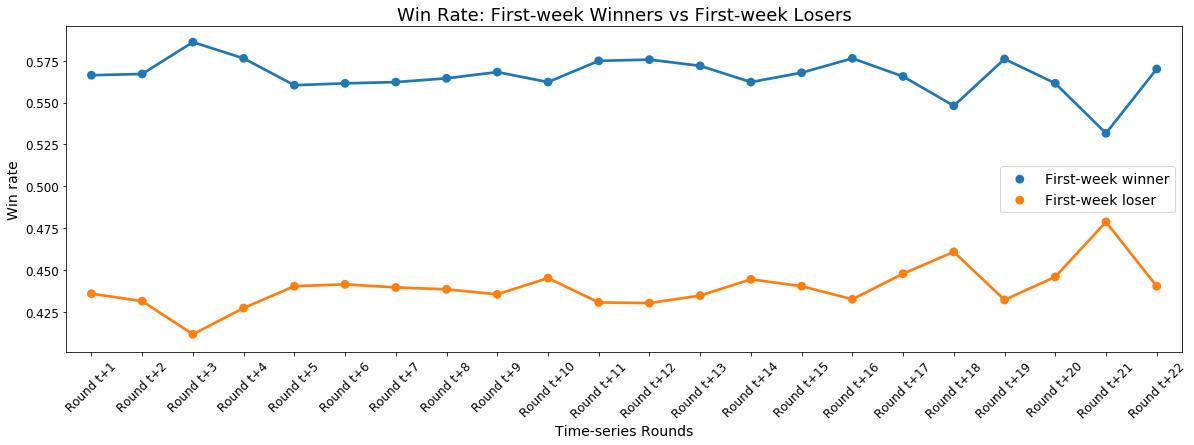

In [16]:
# Plot win rates of first week winners vs first week losers

overall_winners_mean = first_week_winners.mean().drop('win_22').mean()
overall_losers_mean = first_week_losers.mean().drop('win_22').mean()
relative_winners_mean = first_week_winners.mean().drop('win_22')
relative_losers_mean = first_week_losers.mean().drop('win_22')
first_week_results = {
    'One-week Win Rate': relative_winners_mean[::-1].append(relative_losers_mean[::-1]),
    'Team Type': ['First-week winner'] * 22 + ['First-week loser'] * 22
}
first_week_results_df = pd.DataFrame(first_week_results).reset_index()

plt.figure(figsize=(20,6))
ax = sns.pointplot(x='index', y='One-week Win Rate', hue='Team Type', data=first_week_results_df, ci=None)
plt.title('Win Rate: First-week Winners vs First-week Losers', fontsize=18)
plt.legend(fontsize=14)
plt.ylabel('Win rate', fontsize=14)
plt.xlabel('Time-series Rounds', fontsize=14)
plt.yticks(fontsize=12)
locs, _ = plt.xticks()
plt.xticks(locs, ['Round t+{}'.format(n+1) for n in range(23)], fontsize=12, rotation=45)

plt.show()

No obvious relationship between this week's results and following weeks beyond the fact that teams that win in any given week tend to win in any other given week (~56.6%) and same for losers (~43.9%).

It's kind of interesting that taking the winners in any given week and always tipping them during a one-season period gives you roughly the same accuracy as always tipping the home team, but it doesn't really help with developing a more-sophisticated tipping strategy.

In [17]:
# For winners last week, how many predicted to win the week after vs how many actually won

last_week_winners = (time_series_df['win_1'] == 1)
print(last_week_winners.sum(), '\n')
print('Predicted win rate for last week\'s winners:',
      pred_series_df[last_week_winners]['pred_win_0'].mean())
print('Real win rate of last week\'s winners',
      time_series_df[last_week_winners]['win_0'].mean())

1357 

Predicted win rate for last week's winners: 0.619012527634
Real win rate of last week's winners 0.560427413412


In [18]:
# For winners two weeks in a row, how many predicted to win the week after vs how many actually won

two_week_winners = last_week_winners & (time_series_df['win_2'] ==1)
print(two_week_winners.sum(), '\n')
print('Predicted win rate for two-week winners:',
      pred_series_df[two_week_winners]['pred_win_0'].mean())
print('Real win rate of two-week winners',
      time_series_df[two_week_winners]['win_0'].mean())

755 

Predicted win rate for two-week winners: 0.707284768212
Real win rate of two-week winners 0.598013245033


In [19]:
# For winners three weeks in a row, how many predicted to win the week after vs how many actually won

three_week_winners = two_week_winners & (time_series_df['win_3'] ==1)
print(three_week_winners.sum(), '\n')
print('Predicted win rate for three-week winners:',
      pred_series_df[three_week_winners]['pred_win_0'].mean())
print('Real win rate of three-week winners',
      time_series_df[three_week_winners]['win_0'].mean())

449 

Predicted win rate for three-week winners: 0.766146993318
Real win rate of three-week winners 0.632516703786


In [28]:
# For winners four weeks in a row, how many predicted to win the week after vs how many actually won

four_week_winners = three_week_winners & (time_series_df['win_4'] ==1)
print(four_week_winners.sum(), '\n')
print('Predicted win rate for four-week winners:',
      pred_series_df[four_week_winners]['pred_win_0'].mean())
print('Real win rate of four-week winners',
      time_series_df[four_week_winners]['win_0'].mean())

282 

Predicted win rate for four-week winners: 0.812056737589
Real win rate of four-week winners 0.679078014184


More evidence of betting odds amplifying conventional wisdom. As teams win more recent games, they're win rate for next week increases by ~3% per game-in-a-row won, but their predicted win rate starts out ~5% too high, and increases at a faster rate than the real win rate.

In [29]:
print('Last week\'s winner rolling win rate:', rolling_df[last_week_winners]['rolling_win_rate_23'].mean())
print('Two-week winner rolling win rate:', rolling_df[two_week_winners]['rolling_win_rate_23'].mean())
print('Three-week winner rolling win rate:', rolling_df[three_week_winners]['rolling_win_rate_23'].mean())
print('Four-week winner rolling win rate:', rolling_df[four_week_winners]['rolling_win_rate_23'].mean())

Last week's winner rolling win rate: 0.57768094582
Two-week winner rolling win rate: 0.63414915059
Three-week winner rolling win rate: 0.681708143701
Four-week winner rolling win rate: 0.723558433549


Now this is interesting. Comparing the win rate after a given winning streak to the average win rate of those same teams during those same rounds, we find that there is actually some regression to the mean. Namely, the win rate after a winning streak is actually lower than that team's rolling win rate, and their rolling win rate is still lower than their predicted win rate.

In [30]:
print('Last week\'s winner rolling predicted win rate:', rolling_df[last_week_winners]['rolling_pred_win_rate_23'].mean())
print('Two-week winner rolling predicted win rate:', rolling_df[two_week_winners]['rolling_pred_win_rate_23'].mean())
print('Three-week winner rolling predicted win rate:', rolling_df[three_week_winners]['rolling_pred_win_rate_23'].mean())
print('Four-week winner rolling predicted win rate:', rolling_df[four_week_winners]['rolling_pred_win_rate_23'].mean())

Last week's winner rolling predicted win rate: 0.590336740252
Two-week winner rolling predicted win rate: 0.652001151742
Three-week winner rolling predicted win rate: 0.703398857364
Four-week winner rolling predicted win rate: 0.747301880974


As expected, these teams' predicted win rate is higher than their real win rate, but their one-week predicted win rate is inflated well beyond the rolling average, meaning that there is a strong bias toward favouring teams that have won recently. It's like the chump who buys a stock that's been rapidly increasing in value for weeks, because of course it's going to keep going up forever, only to have that same hot stock crash the next day. Past results are not indicative of future returns, my friend.

In [31]:
print('Last week\'s winner betting accuracy:', rolling_df[last_week_winners]['correct_pred'].mean())
print('Two-week winner betting accuracy:', rolling_df[two_week_winners]['correct_pred'].mean())
print('Three-week winner betting accuracy:', rolling_df[three_week_winners]['correct_pred'].mean())
print('Four-week winner betting accuracy:', rolling_df[four_week_winners]['correct_pred'].mean())

Last week's winner betting accuracy: 0.714075165807
Two-week winner betting accuracy: 0.701986754967
Three-week winner betting accuracy: 0.714922048998
Four-week winner betting accuracy: 0.72695035461


In [34]:
# Check that losing teams have a similar pattern

last_week_losers = (time_series_df['win_1'] == 0)

print('Predicted win rate for last week\'s losers:',
      pred_series_df[last_week_losers]['pred_win_0'].mean())
print('Real win rate of last week\'s losers',
      time_series_df[last_week_losers]['win_0'].mean())
print()

two_week_losers = last_week_losers & (time_series_df['win_2'] == 0)

print('Predicted win rate for two week losers:',
      pred_series_df[two_week_losers]['pred_win_0'].mean())
print('Real win rate of two week losers',
      time_series_df[two_week_losers]['win_0'].mean())
print()

three_week_losers = two_week_losers & (time_series_df['win_3'] == 0)

print('Predicted win rate for three week losers:',
      pred_series_df[three_week_losers]['pred_win_0'].mean())
print('Real win rate of three week losers',
      time_series_df[three_week_losers]['win_0'].mean())
print()

four_week_losers = three_week_losers & (time_series_df['win_4'] == 0)

print('Predicted win rate for four week losers:',
      pred_series_df[four_week_losers]['pred_win_0'].mean())
print('Real win rate of four week losers',
      time_series_df[four_week_losers]['win_0'].mean())
print()

Predicted win rate for last week's losers: 0.397735849057
Real win rate of last week's losers 0.451320754717

Predicted win rate for two week losers: 0.302486187845
Real win rate of two week losers 0.391574585635

Predicted win rate for three week losers: 0.215909090909
Real win rate of three week losers 0.317045454545

Predicted win rate for four week losers: 0.158940397351
Real win rate of four week losers 0.258278145695



In [33]:
# Pred/Real win rates for all teams
# NOTE: It's not quite 50% due to draws counting as wins,
# and the rates differ because predicted is randomised for matches without a favourite
# and real counts draws as 0.5 wins

print('Predicted win rate:',
      pred_series_df['pred_win_0'].mean())
print('Real win rate',
      time_series_df['win_0'].mean())

Predicted win rate: 0.509615384615
Real win rate 0.506286982249


In [36]:
print('All teams\'s rolling win rate:', rolling_df['rolling_win_rate_23'].mean())
print('Last week\'s loser rolling win rate:', rolling_df[last_week_losers]['rolling_win_rate_23'].mean())
print('Two-week loser rolling win rate:', rolling_df[two_week_losers]['rolling_win_rate_23'].mean())
print('Three-week loser rolling win rate:', rolling_df[three_week_losers]['rolling_win_rate_23'].mean())
print('Four-week loser rolling win rate:', rolling_df[four_week_losers]['rolling_win_rate_23'].mean())

All teams's rolling win rate: 0.49926035503
Last week's loser rolling win rate: 0.418933552092
Two-week loser rolling win rate: 0.344583233245
Three-week loser rolling win rate: 0.28942687747
Four-week loser rolling win rate: 0.251511661388


## Correlations of week-on-week win rates and scores

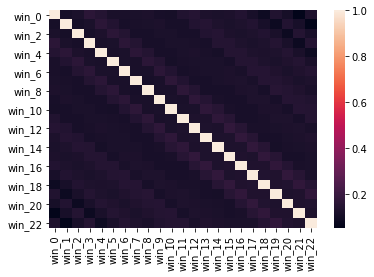

In [22]:
# Calculate correlation among wins across time and display on heatmap

corr_df = time_series_df.corr()
sns.heatmap(corr_df)
plt.show()

In [23]:
corr_df

win_0     win_1     win_2     win_3     win_4     win_5     win_6  \
win_0   1.000000  0.109113  0.120682  0.162456  0.143819  0.116181  0.116978   
win_1   0.109113  1.000000  0.110621  0.122188  0.162470  0.140789  0.115492   
win_2   0.120682  0.110621  1.000000  0.113618  0.123694  0.161669  0.142346   
win_3   0.162456  0.122188  0.113618  1.000000  0.116615  0.120672  0.163234   
win_4   0.143819  0.162470  0.123694  0.116615  1.000000  0.115833  0.119984   
win_5   0.116181  0.140789  0.161669  0.120672  0.115833  1.000000  0.119567   
win_6   0.116978  0.115492  0.142346  0.163234  0.119984  0.119567  1.000000   
win_7   0.119597  0.116992  0.115505  0.142359  0.161754  0.116218  0.115894   
win_8   0.123653  0.119558  0.113971  0.114722  0.142310  0.163869  0.116969   
win_9   0.113182  0.124365  0.121016  0.115432  0.113946  0.142211  0.163879   
win_10  0.111701  0.114685  0.121396  0.119537  0.115443  0.111675  0.140784   
win_11  0.136717  0.113983  0.114732  0.121446  0.121822  0.117678  0.112508   
win_12  0.149026  0.139711  0.115485  0.119216  0.124438  0.120293  0.117732   
win_13  0.126688  0.147563  0.141228  0.115511  0.119240  0.120686  0.120360   
win_14  0.121469  0.127435  0.146819  0.141975  0.111785  0.120686  0.122969   
win_15  0.125206  0.121480  0.125954  0.145337  0.141984  0.112496  0.124467   
win_16  0.139370  0.127444  0.122226  0.129682  0.144593  0.144912  0.116266   
win_17  0.114024  0.141608  0.129681  0.122973  0.130429  0.144539  0.147949   
win_18  0.086449  0.115524  0.141617  0.129690  0.124472  0.128897  0.146091   
win_19  0.137889  0.085705  0.117761  0.143854  0.130436  0.120700  0.131928   
win_20  0.111060  0.140880  0.085714  0.117770  0.145352  0.131139  0.122988   
win_21  0.052921  0.112560  0.142379  0.085722  0.119268  0.143815  0.131941   
win_22  0.129716  0.052930  0.115549  0.143877  0.087220  0.117740  0.143875   

           win_7     win_8     win_9    ...       win_13    win_14    win_15  \
win_0   0.119597  0.123653  0.113182    ...     0.126688  0.121469  0.125206   
win_1   0.116992  0.119558  0.124365    ...     0.147563  0.127435  0.121480   
win_2   0.115505  0.113971  0.121016    ...     0.141228  0.146819  0.125954   
win_3   0.142359  0.114722  0.115432    ...     0.115511  0.141975  0.145337   
win_4   0.161754  0.142310  0.113946    ...     0.119240  0.111785  0.141984   
win_5   0.116218  0.163869  0.142211    ...     0.120686  0.120686  0.112496   
win_6   0.115894  0.116969  0.163879    ...     0.120360  0.122969  0.124467   
win_7   1.000000  0.115111  0.117681    ...     0.114771  0.119617  0.125959   
win_8   0.115111  1.000000  0.116893    ...     0.114728  0.113983  0.114362   
win_9   0.117681  0.116893  1.000000    ...     0.148208  0.118412  0.114693   
win_10  0.166870  0.116898  0.119837    ...     0.168323  0.151935  0.116929   
win_11  0.140840  0.166870  0.118392    ...     0.123675  0.170621  0.150506   
win_12  0.115500  0.143774  0.169796    ...     0.127403  0.124422  0.175098   
win_13  0.114771  0.114728  0.148208    ...     1.000000  0.129645  0.127412   
win_14  0.119617  0.113983  0.118412    ...     0.129645  1.000000  0.130393   
win_15  0.125959  0.114362  0.114693    ...     0.127412  0.130393  1.000000   
win_16  0.128195  0.126657  0.115065    ...     0.175848  0.128903  0.131140   
win_17  0.117013  0.128893  0.128101    ...     0.152003  0.175848  0.128159   
win_18  0.147956  0.114740  0.128851    ...     0.112511  0.149770  0.175852   
win_19  0.143856  0.150136  0.112464    ...     0.115492  0.111021  0.150516   
win_20  0.133425  0.143808  0.147107    ...     0.120338  0.116240  0.112515   
win_21  0.120013  0.133381  0.145250    ...     0.123694  0.121086  0.114752   
win_22  0.127474  0.117739  0.137062    ...     0.132639  0.125932  0.122579   

          win_16    win_17    win_18    win_19    win_20    win_21    win_22  
win_0   0.139370  0.114024  0.086449  0.137889  0.111060  0.052921  0.129716  
win_1   0.1

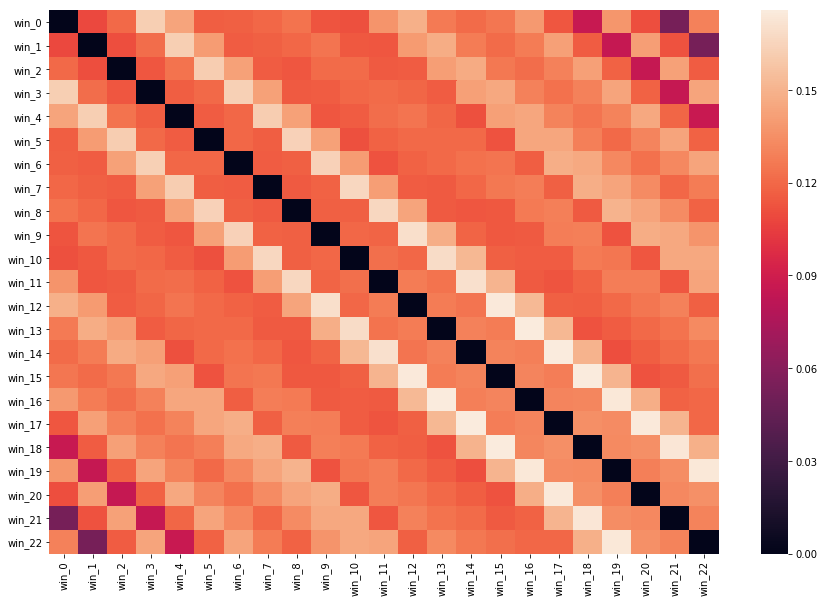

In [24]:
# Given low correlations, set diagonal to 0 to bring out the color gradient more

scaled_corr_df = corr_df.copy()

for col in scaled_corr_df.columns.values:
    scaled_corr_df.loc[col, col] = 0

plt.figure(figsize=(15, 10))
sns.heatmap(scaled_corr_df)
plt.show()

It could be a fluke, but there is a weirdly strong correlation between winning this week and winning three weeks ago.

In [25]:
# Create the same type of t-n time series table, but with score differences instead of win/loss
# This should give a better spread of values

score_series_cols = []

for n in range(23):
    score_col = rolling_df['score_diff'].groupby(level=0).shift(n).rename('score_diff_{}'.format(n))
    score_series_cols.append(score_col)

score_series_df = pd.concat(score_series_cols, axis=1).dropna()
score_series_df

score_diff_0  score_diff_1  score_diff_2  \
team             year round_number                                             
Adelaide         2012 1                     69.0         -95.0         -22.0   
                      2                     18.0          69.0         -95.0   
                      3                    -56.0          18.0          69.0   
                      4                     46.0         -56.0          18.0   
                      5                     19.0          46.0         -56.0   
                      6                      5.0          19.0          46.0   
                      7                     50.0           5.0          19.0   
                      8                     69.0          50.0           5.0   
                      9                    -26.0          69.0          50.0   
                      10                    29.0         -26.0          69.0   
                      12                     4.0          29.0         -26.0   
                      13                   -32.0           4.0          29.0   
                      14                    19.0         -32.0           4.0   
                      15                    58.0          19.0         -32.0   
                      16                   119.0          58.0          19.0   
                      17                    49.0         119.0          58.0   
                      18                   -27.0          49.0         119.0   
                      19                     4.0         -27.0          49.0   
                      20                    28.0           4.0         -27.0   
                      21                   -10.0          28.0           4.0   
                      22                    69.0         -10.0          28.0   
                      23                    91.0          69.0         -10.0   
                 2013 1                    -35.0          91.0          69.0   
                      2                     19.0         -35.0          91.0   
                      3                     -9.0          19.0         -35.0   
                      4                     52.0          -9.0          19.0   
                      5                    -32.0          52.0          -9.0   
                      6                    -11.0         -32.0          52.0   
                      7                    135.0         -11.0         -32.0   
                      8                     40.0         135.0         -11.0   
...                                          ...           ...           ...   
Western Bulldogs 2016 16                    10.0           4.0         -57.0   
                      17                    48.0          10.0           4.0   
                      18                   -15.0          48.0          10.0   
                      19                   -25.0         -15.0          48.0   
                      20                    14.0         -25.0         -15.0   
                      21                     3.0          14.0         -25.0   
                      22                    40.0           3.0          14.0   
                      23                   -20.0          40.0           3.0   
                 2017 1                     14.0         -20.0          40.0   
                      2                     23.0          14.0         -20.0   
                      3                    -16.0          23.0          14.0   
                      4                      3.0         -16.0          23.0   
                      5                     32.0           3.0         -16.0   
                      6                     -2.0          32.0           3.0   
                      7                      5.0          -2.0          32.0   
                      8                     -8.0           5.0          -2.0   
                      9                    -23.0          -8.0           5.0   
                      10            


This Week's Score vs t-1 Week's Score

Correlation: 0.165092753097
Pearson R^2:  0.0272556171251


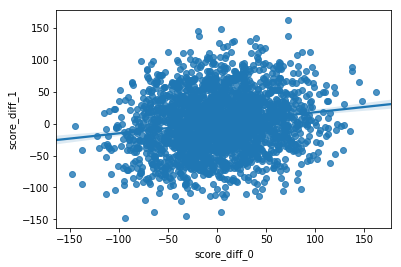


This Week's Score vs t-2 Week's Score

Correlation: 0.170617047201
Pearson R^2:  0.0291101767956


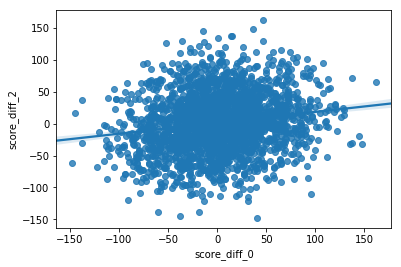


This Week's Score vs t-3 Week's Score

Correlation: 0.224526515221
Pearson R^2:  0.0504121560374


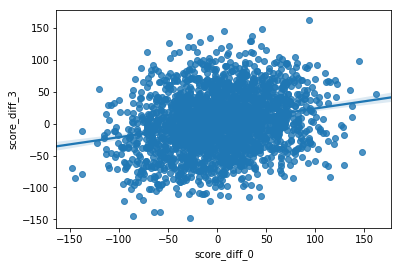


This Week's Score vs t-4 Week's Score

Correlation: 0.189187489288
Pearson R^2:  0.0357919061031


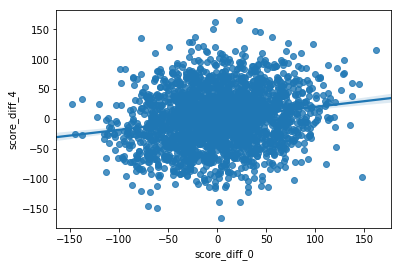


This Week's Score vs t-5 Week's Score

Correlation: 0.142783317669
Pearson R^2:  0.0203870758045


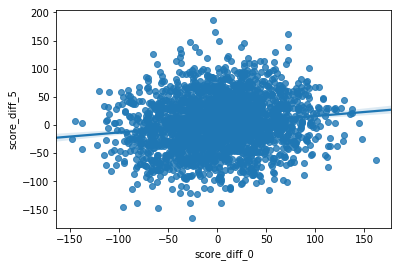


This Week's Score vs t-6 Week's Score

Correlation: 0.19395009573
Pearson R^2:  0.0376166396336


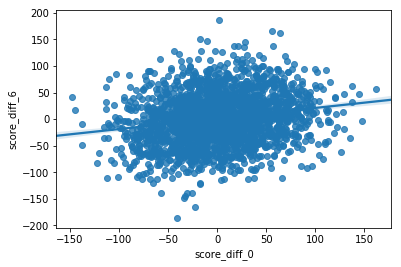


This Week's Score vs t-7 Week's Score

Correlation: 0.171599490232
Pearson R^2:  0.029446385048


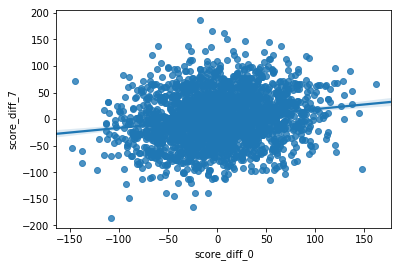


This Week's Score vs t-8 Week's Score

Correlation: 0.165612497616
Pearson R^2:  0.0274274993667


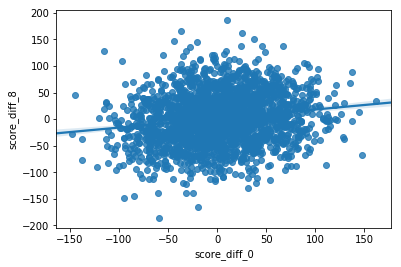


This Week's Score vs t-9 Week's Score

Correlation: 0.172593463823
Pearson R^2:  0.0297885037544


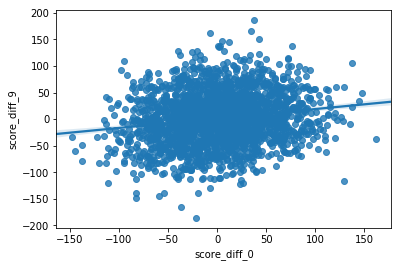


This Week's Score vs t-10 Week's Score

Correlation: 0.149037998181
Pearson R^2:  0.0222123249018


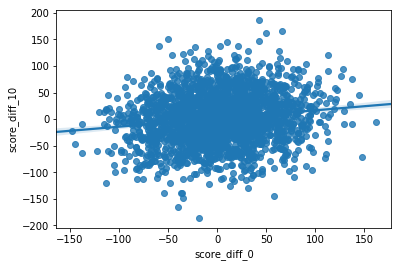


This Week's Score vs t-11 Week's Score

Correlation: 0.165366419946
Pearson R^2:  0.0273460528457


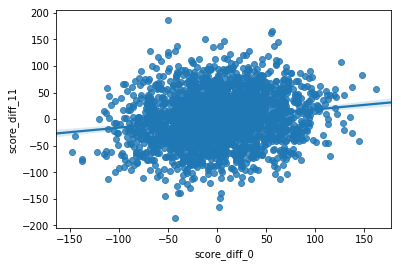


This Week's Score vs t-12 Week's Score

Correlation: 0.165128287763
Pearson R^2:  0.0272673514197


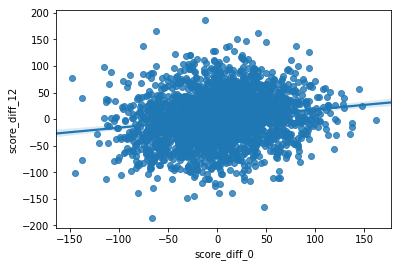


This Week's Score vs t-13 Week's Score

Correlation: 0.153804143719
Pearson R^2:  0.023655714625


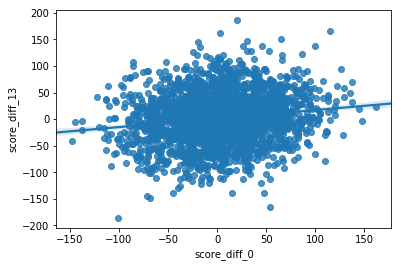


This Week's Score vs t-14 Week's Score

Correlation: 0.170885651936
Pearson R^2:  0.0292019060376


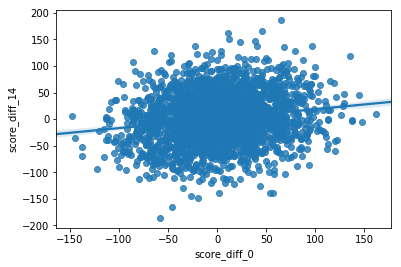


This Week's Score vs t-15 Week's Score

Correlation: 0.185036599069
Pearson R^2:  0.0342385429951


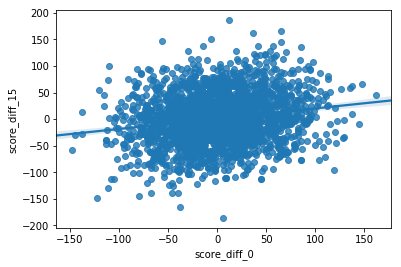


This Week's Score vs t-16 Week's Score

Correlation: 0.163746434261
Pearson R^2:  0.0268128947333


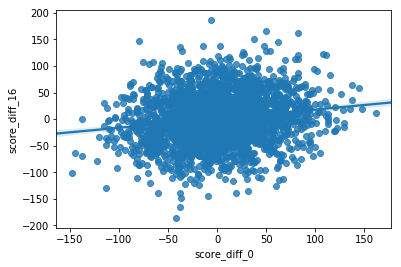


This Week's Score vs t-17 Week's Score

Correlation: 0.161250320117
Pearson R^2:  0.0260016657378


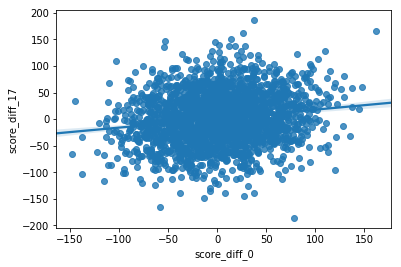


This Week's Score vs t-18 Week's Score

Correlation: 0.184271033217
Pearson R^2:  0.0339558136827


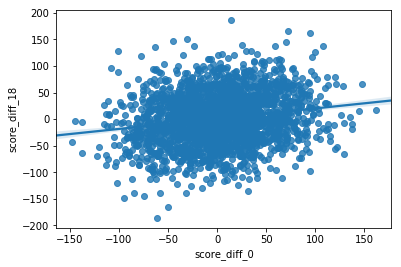


This Week's Score vs t-19 Week's Score

Correlation: 0.157954973121
Pearson R^2:  0.0249497735338


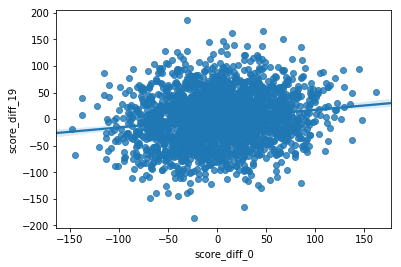


This Week's Score vs t-20 Week's Score

Correlation: 0.143035147619
Pearson R^2:  0.0204590534544


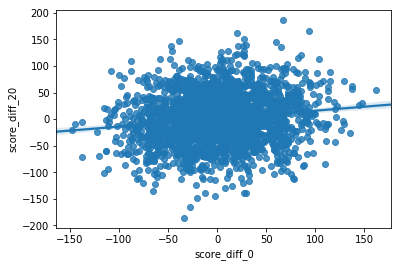


This Week's Score vs t-21 Week's Score

Correlation: 0.146814368068
Pearson R^2:  0.0215544586713


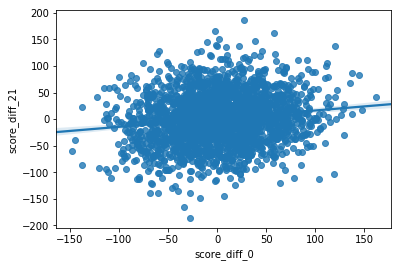


This Week's Score vs t-22 Week's Score

Correlation: 0.183751273346
Pearson R^2:  0.0337645304564


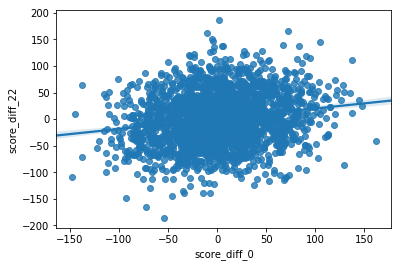

In [26]:
from scipy import stats

for n in range(1, 23):
    print('\nThis Week\'s Score vs t-{} Week\'s Score\n'.format(n))
    print('Correlation:', score_series_df[['score_diff_0', 'score_diff_{}'.format(n)]].corr().iloc[0, 1])
    print('Pearson R^2: ',
          stats.pearsonr(score_series_df['score_diff_0'], score_series_df['score_diff_{}'.format(n)])[0] ** 2)
    sns.regplot(x='score_diff_0', y='score_diff_{}'.format(n), data=score_series_df)
    plt.show()

There's a slightly larger correlation for score than for wins (0.165 vs 0.109 for t-0 vs t-1), but it's still weak, and the scatter plot resembles nothing so much as a cartoon cloud that follows around the protagonist, dumping rain on them.

The fact that the correlation doesn't seem to diminish with distance (in time) from the present is damning: good teams tend to be good over multiple rounds, and bad teams tend to be bad. How well a team did in a past round tells you whether they're likely to be a good team or a bad team, but not anything about short-term patterns in winning or losing over time, regardless of team quality.

In [27]:
# For comparison, correlation between home/away and score differential

print('Correlation between home team and score difference:', rolling_df[['score_diff', 'home_team']].corr().iloc[0, 1])

Correlation between home team and score difference: 0.14534524938
